# Data Preprocessing

## Goals for Today

- **Neuroscience / Neuroimaging concepts**
    * Scanner artifacts
    * Motion correction
    * Slice time correction
    * Interpolation (linear and cubic)
    * Temporal Filtering (highpass filtering)
    * Spatial Filtering (Gaussian filtering)
    * Temporal Normalization (Z-Score)

# Standard Imports

This cell will import the Python modules needed for today's lecture. Simply run this cell.

In [1]:
# Load some necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import nibabel
import cortex
import os
import copy
import urllib.request
from nipype.interfaces import fsl
from __future__ import print_function
from ipywidgets import interact, Image, widgets

# Set plotting defaults
%matplotlib inline

# make sure nipype uses zipped NIFTI files
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

## Data Preparation

This cell will load data necessary for today's lecture. Simply run this cell.

In [2]:
fname = '../../data/fMRI/categories/s01_categories_01.nii.gz'
nii = nibabel.load(fname) 
data_preproc = nii.get_fdata().T
print('data shape : ', data_preproc.shape)

# # make an output folder
# if not os.path.exists('output'):
#     os.mkdir('output')

# # download the data we'll be using today
# filename_nopreproc = 'output/nopreproc_rotated.nii'
# _ = urllib.request.urlretrieve('https://berkeley.box.com/shared/static/x4dd2k5jh86njm19220y54rkh5s42vw0.nii', filename_nopreproc)
# filename_nopreproc_original = 'output/nopreproc_original.nii.gz'
# _ = urllib.request.urlretrieve('https://berkeley.box.com/shared/static/xaxel1xj4npmvlsa1ijdxyvqgxf00op5.gz', filename_nopreproc_original)
# filename_nopreproc_corrected = 'output/nopreproc_corrected.nii'
# _ = urllib.request.urlretrieve('https://berkeley.box.com/shared/static/7r83ol7i3zikdekx4gds2n95vyyecxie.nii', filename_nopreproc_corrected)

# # load the data that hasn't been preprocessed
# img_nopreproc_raw = nibabel.load(filename_nopreproc)
# data_nopreproc = img_nopreproc_raw.get_data().T
# img_nopreproc_original = nibabel.load(filename_nopreproc_original)
# data_nopreproc_original = img_nopreproc_original.get_data().T
# img_nopreproc_corrected = nibabel.load(filename_nopreproc_corrected)
# data_nopreproc_corrected = img_nopreproc_corrected.get_data().T

# # load the data that has been prepocessed and can be drawn on a flatmap
# img_preproc = nibabel.load("/data/cogneuro/fMRI/categories/s01_categories_01.nii.gz")
# data_preproc = img_preproc.get_data().T

data shape :  (120, 30, 100, 100)


# Review

## Masking

Masking is a subsetting technique that uses an array of boolean (True/False) values to indicate which indices to keep in the subset. It can be applied to all of the axes of an array, or only a subset of them. It always reduces the number of dimension that are masked to 1. It is very similar to indexing, and can be considered a subset of indexing. We learned to create two kinds of masks that can be used on 3-D Volume data: brain masks and cortical masks. Let's review both here.

### Brain Masks

Brain masks include all of the voxels in the brain, including CSF, white matter and gray matter. We create a brain mask by choosing a threshold value to select brain vs. outside of brain voxels. In order to determine that threshold we will plot a histogram of all the voxel values and look for the start of the second peak of the distribution.

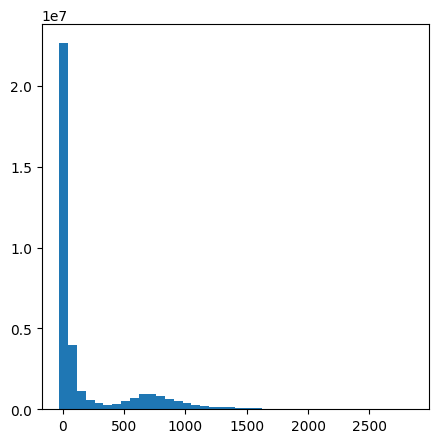

In [3]:
fig = plt.figure(figsize=(5,5))
_ = plt.hist(data_preproc.flatten(), bins=40)

It looks like the threshold starts around 400, so we'll use that as a threshold, and create a mask. We'll create the mask by looking at the mean of all the volumes across time, because that is less susceptible to noise fluctuations.

In [4]:
data_preproc_mean = data_preproc.mean(axis=0)
brain_mask = data_preproc_mean > 400
brain_mask.shape

(30, 100, 100)

To apply a mask we use bracket notation as with indexing and slicing, and add the name of the mask into the axis or axes we want to mask. We'll mask a 4-D scan array, so we want to keep the time dimension and mask the 3 spatial dimensions. We should end up with a 2-D collection of voxel time series.

In [5]:
data_preproc_brainmasked = data_preproc[:, brain_mask]
data_preproc_brainmasked.shape

(120, 58873)

### Cortical Masks

Cortical masks are a subset of brain masks. They only contain the grey matter that is in the cortex. These masks are more precise than brains masks because they're not created using a threshold, rather based on a **segmentation** that is done by FreeSurfer. **Segmentation** labels each voxel as belonging to CSF, white matter or gray matter, and then the corical mask includes only those gray matter voxels in the cortex. We use the pycortex module to retrieve a cortical mask.

In [6]:
subject = 's01'
transform = 'catloc'
cortical_mask = cortex.db.get_mask(subject, transform, type='cortical')
cortical_mask.shape

(30, 100, 100)

Let's apply the cortical mask

In [7]:
data_preproc_corticalmasked = data_preproc[:, cortical_mask]
data_preproc_corticalmasked.shape

(120, 38543)

Let's create a histogram of the brain voxels and a second histogram of the cortical voxels. What do you notice?

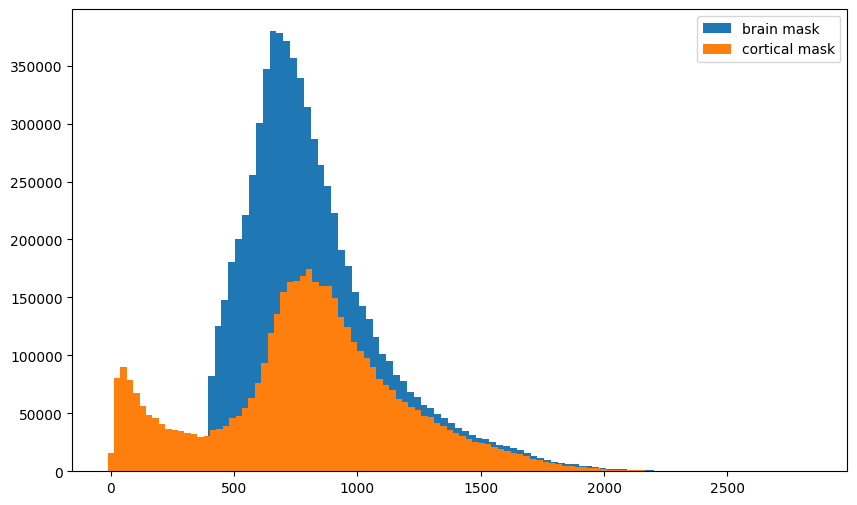

In [8]:
fig = plt.figure(figsize=(10, 6))
h1 = plt.hist(data_preproc_brainmasked.flatten(), bins=100, label='brain mask')
h2 = plt.hist(data_preproc_corticalmasked.flatten(), bins=100, label='cortical mask')
plt.legend()

## Visualization of 3-D Volume Arrays

We learned two ways to visualize 3-D volume arrays. The first involved plotting an image of each slice, and the second involved creating cortical flatmaps. 

### Multiple 2-D Slice Images

If we need to see all of the voxels collected in a volume, then we can plot each slice (either axial, coronal or sagittal) onto a separate image, and put them all together into a single figure. To do that more efficiently we learned to use for loops to do a single operation multiple times over a set of values.

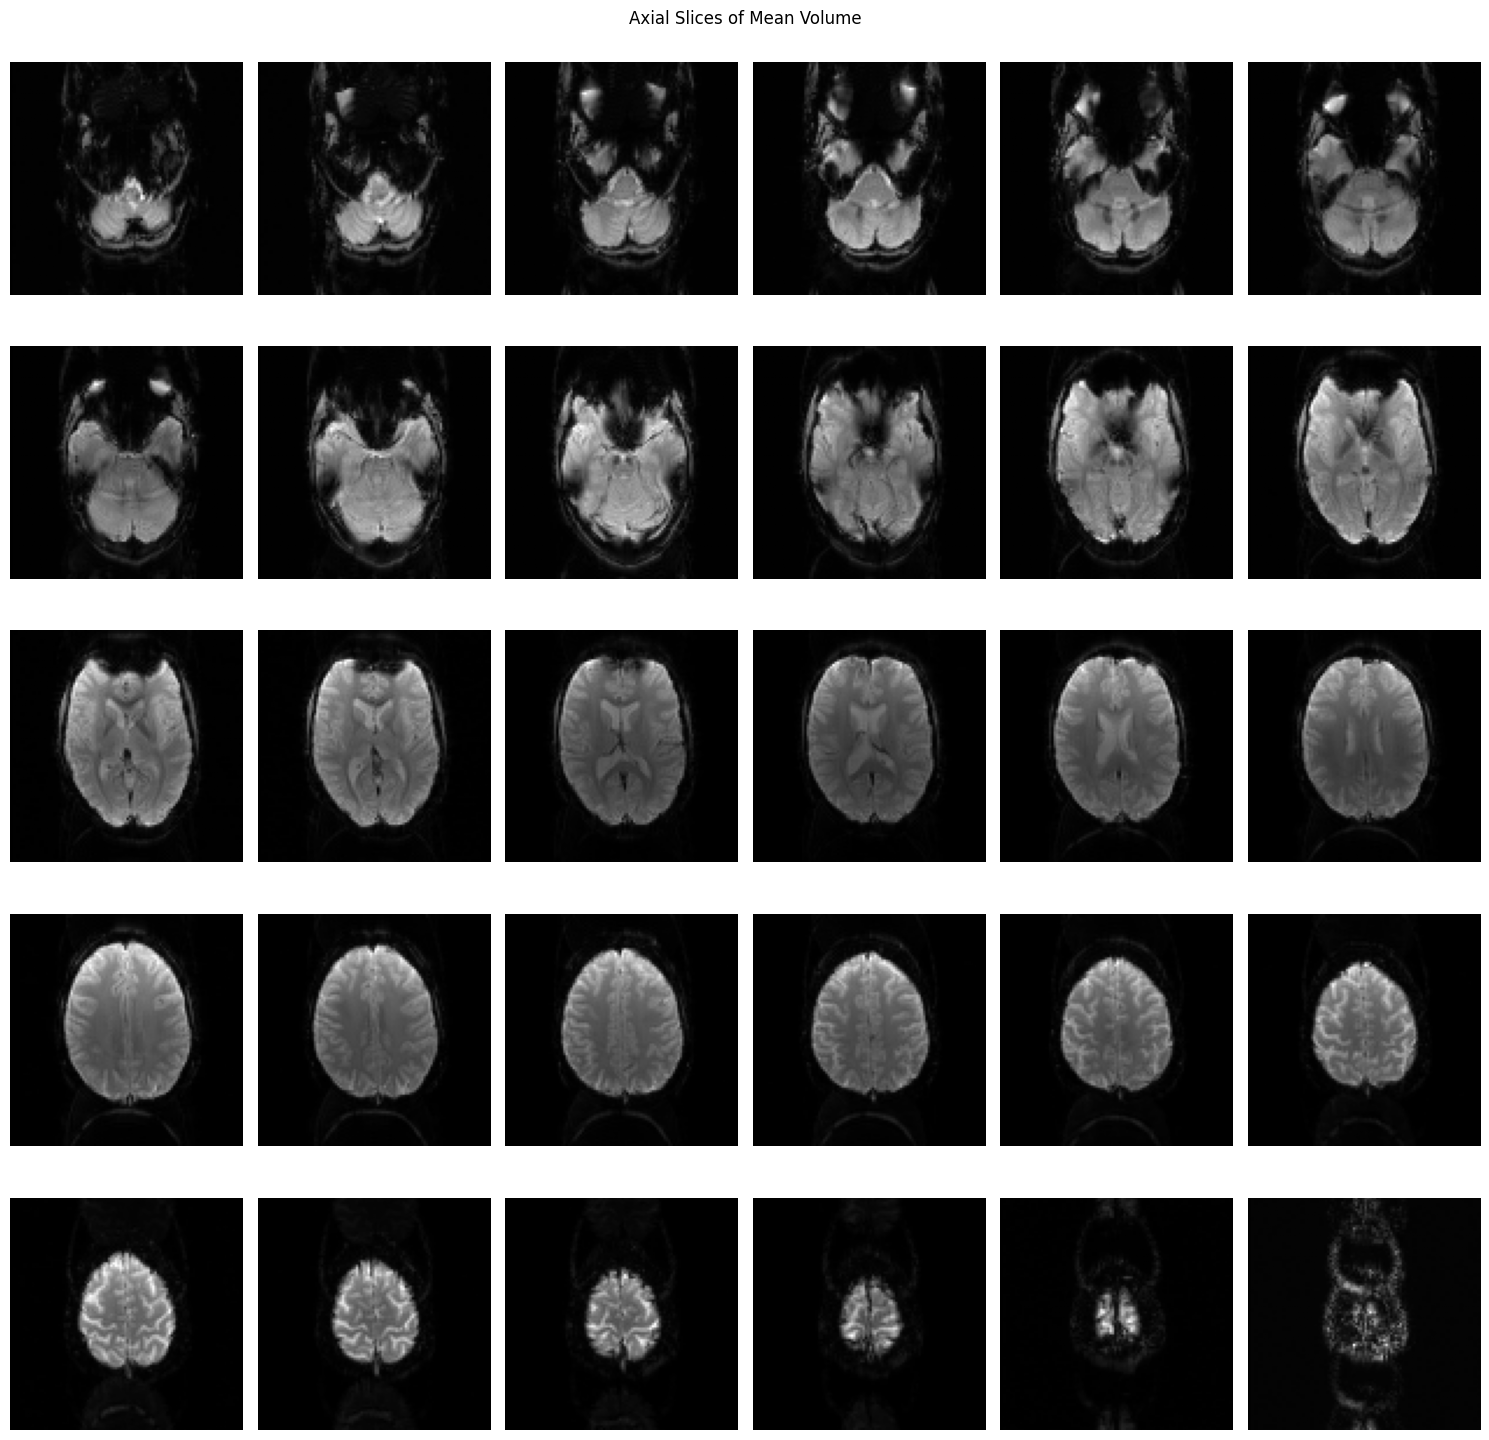

In [9]:
fig = plt.figure(figsize=(15,15))
num_axial_slices = data_preproc.shape[1]
for s in range(num_axial_slices):
    plt.subplot(5, 6, s + 1)
    plt.imshow(data_preproc_mean[s,:,:], cmap='gray')
    plt.axis('off')
    
plt.suptitle('Axial Slices of Mean Volume')
plt.tight_layout()

### An Application of Flatmaps: Signal to Noise Ratio (SNR)

Let's use an example to illustrate how you might use flatmaps to plot some real fMRI data. A big constraint to finding interesting results in fMRI studies is the quality of the data, and we know that fMRI data is **NOISY**!!! One way to quantify data quality is by calculating the **Signal-to-Noise** ratio, or **SNR**, of your data. This ratio is higher when the actual signal you care about is higher relative to the noise in the data. While we can't know this for sure, there are several ways to estimate it.

The most common way is to divide the average of each voxel over time (the signal) by the average standard deviation of all the voxels that lie outside the brain (noise). We'll get into detail about standard deviation later on in this lecture. For now, just know that standard deviation is a measure of how much the data tends to differ from the mean, so it's a measure of a signal's fluctuation. 

Let's calculate the signal to noise ratio for some data, and then plot it on a flatmap. We'll start by calculating the **signal** of the data.

In [10]:
signal = np.mean(data_preproc, axis=0)
signal.shape

(30, 100, 100)

Now we'll define a function that will calculate the noise. You don't need to worry about the details yet, we'll cover that more later. The intuition is that this function will measure how much each voxel outside of the brain fluctuates over time, and take the average (or mean) of all of those fluctuations. We use outside the brain voxels because we assume the only thing affecting the BOLD signal in those voxels is noise the scanner records, since those voxels are just measuring air. 

In [11]:
def calc_noise(data):
    
    # determine the voxels that are outside the brain, 
    # assuming their value is around 300 in the first volume
    outside_brain_mask = data[0] <= 300
    
    # get all the voxels that are not in the brain, for each time point
    outside_brain_vox = data[:,outside_brain_mask]
    
    # find the standard deviation of the voxels outside the brain, for
    # each volume across time
    data_std = np.std(outside_brain_vox, axis=0)
    
    # take the average of all of those standard deviations
    noise = np.mean(data_std)
    return noise

Now let's use this helper function on the data to calculate a single number that represents the noise.

In [12]:
# now detrend the data using the above function
noise = calc_noise(data_preproc)
noise

np.float64(5.057238251698836)

Finally, to calculate the signal to noise, we'll divide the signal (for which we have a number for each voxel) by the single noise value. The result will be a 3-D volume array. 

In [13]:
# finally create a single volume that has the SNR for each volume
# by dividing the signal by the noise
snr = signal / noise

We learned about `cortex.Volume` last week, which stores data, and information about the subject and transformation for that data. This is what pycortex uses when creating flatmaps or interactive maps.

Now that we have a volume containing the SNR values for all of our voxels, let's plot it!

In [14]:
subject = 's01'
transform = 'catloc'
volume_SNR = cortex.Volume(snr, subject, transform)

Failed to get connection
** (inkscape:2246841): CRITICAL **: 23:37:39.128: dbus_g_proxy_new_for_name: assertion 'connection != NULL' failed
** (inkscape:2246841): CRITICAL **: 23:37:39.128: dbus_g_proxy_call: assertion 'DBUS_IS_G_PROXY (proxy)' failed
** (inkscape:2246841): CRITICAL **: 23:37:39.128: dbus_g_connection_register_g_object: assertion 'connection != NULL' failed
Background RRGGBBAA: ffffff00
Area 0:0:2112.6:1024 exported to 2113 x 1024 pixels (96 dpi)


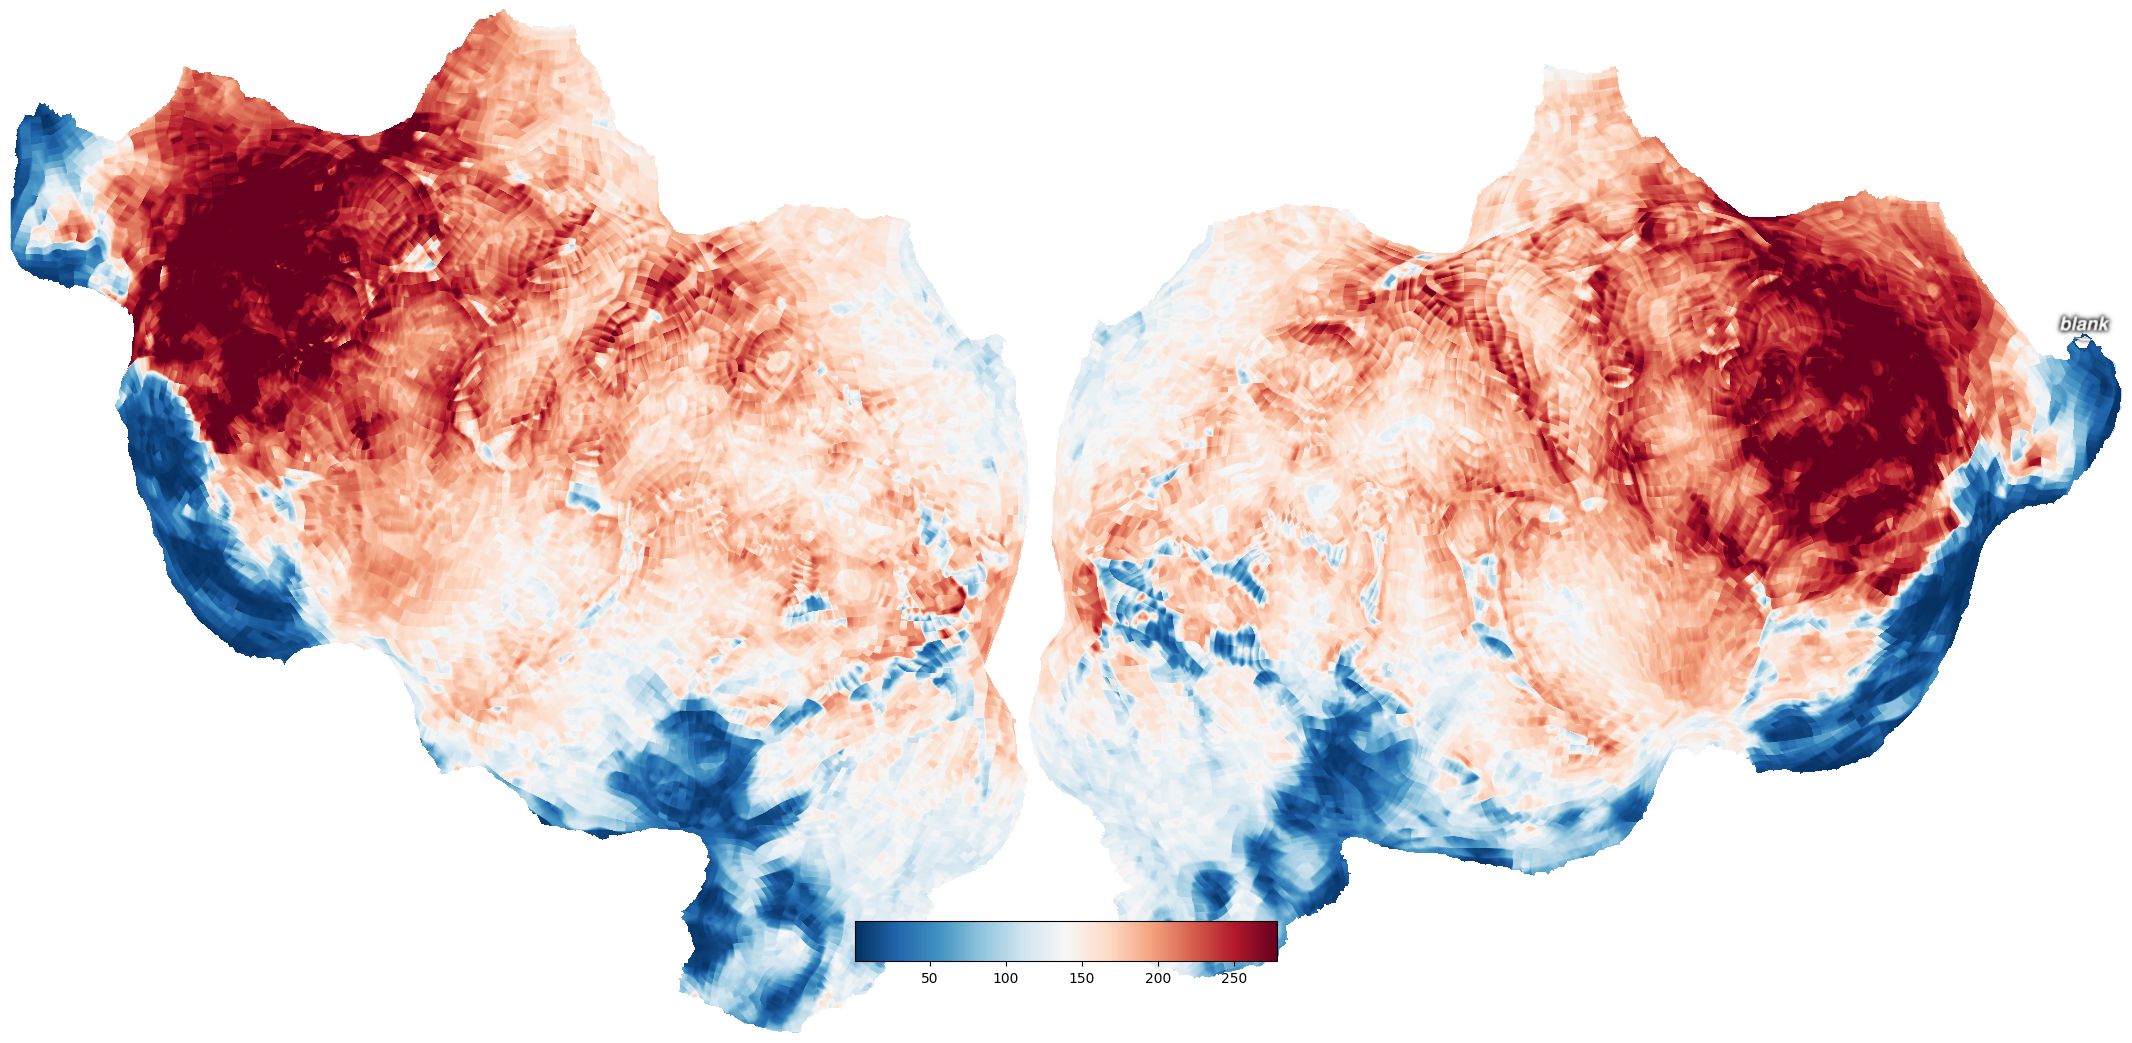

In [16]:
_ = cortex.quickflat.make_figure(volume_SNR, with_colorbar=True)

In [28]:
def get_slice(volume, slice_number, slice_type):
    if slice_type == 'axial':
        selected_slice = volume[slice_number, :, :]
    elif slice_type == 'coronal':
        selected_slice = volume[:, slice_number, :]
    elif slice_type == 'sagittal':
        selected_slice = volume[:, :, slice_number]
    return selected_slice


def plot_slice(volume, slice_number, slice_type, aspect=1.0, title='', flip_top_bottom=False, colormap=None):
    selected_slice = get_slice(volume, slice_number, slice_type)
    if flip_top_bottom:
        selected_slice = selected_slice[::-1, :]
    plt.imshow(selected_slice, aspect=aspect, cmap=colormap)
    plt.title(title)
    _ = plt.axis('off')


def plot_ortho(volume, voxel_indices, voxel_dims=(1,1,1)):
    aspect_coronal = voxel_dims[0] / voxel_dims[2]
    plt.subplot(2, 2, 1)
    plot_slice(volume0, voxel_indices[1], 'coronal', aspect=aspect_coronal, 
               title='Coronal Slice', flip_top_bottom=True, colormap='gray')

    aspect_sagittal = voxel_dims[0] / voxel_dims[1]
    plt.subplot(2, 2, 2)
    plot_slice(volume0, voxel_indices[2], 'sagittal', aspect=aspect_sagittal, 
               title='Sagittal Slice', flip_top_bottom=True, colormap='gray')

    aspect_axial = voxel_dims[1] / voxel_dims[2]
    plt.subplot(2, 2, 3)
    plot_slice(volume0, voxel_indices[0], 'axial', aspect=aspect_axial, 
               title='Axial Slice', flip_top_bottom=False, colormap='gray')    

Now let's pick voxel dimensions:

In [23]:
voxel_dims = (4.1300001, 2.24, 2.24)
middle_voxel_indices = (15,50,50)


And finally use the function!

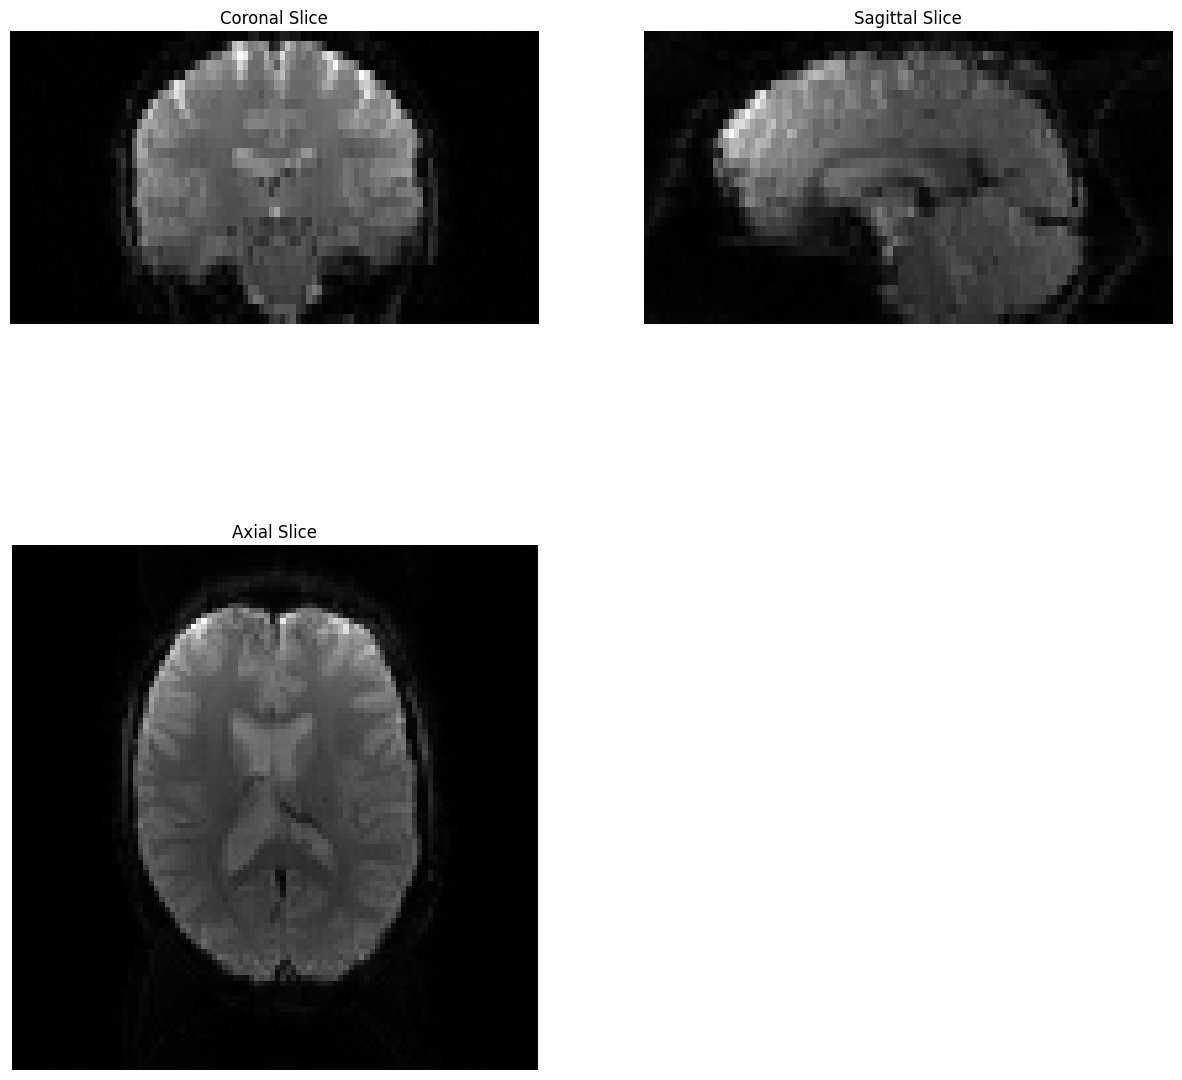

In [29]:
fig = plt.figure(figsize=(15, 15))

volume0 = data_preproc[0,:,:,:]
plot_ortho(volume0, middle_voxel_indices, voxel_dims)

Now let's extend these **helper functions** even further, and create a function that plots all the slices of a volume in a given axis, as we learned to do last week:

In [30]:
def plot_volume_as_slices(volume, slice_type, nrows, ncols, colormap=None, aspect=1.0, flip_top_bottom=False, title='' ):

    # determine how many slices will be created based on the type of slice to plot
    if slice_type == 'axial':
        num_slices = volume.shape[0]
    elif slice_type == 'coronal':
        num_slices = volume.shape[1]
    elif slice_type == 'sagittal':
        num_slices = volume.shape[2]

    # create a figure and plot all the slices using a for loop to iterate over all of them
    for s in range(num_slices):
        plt.subplot(nrows, ncols, s + 1)
        plot_slice(volume, s, slice_type, aspect=aspect, flip_top_bottom=flip_top_bottom, colormap=colormap)
    
    # add a title, and use tight_layout to remove the extra whitespace
    plt.suptitle(title)
    plt.tight_layout()

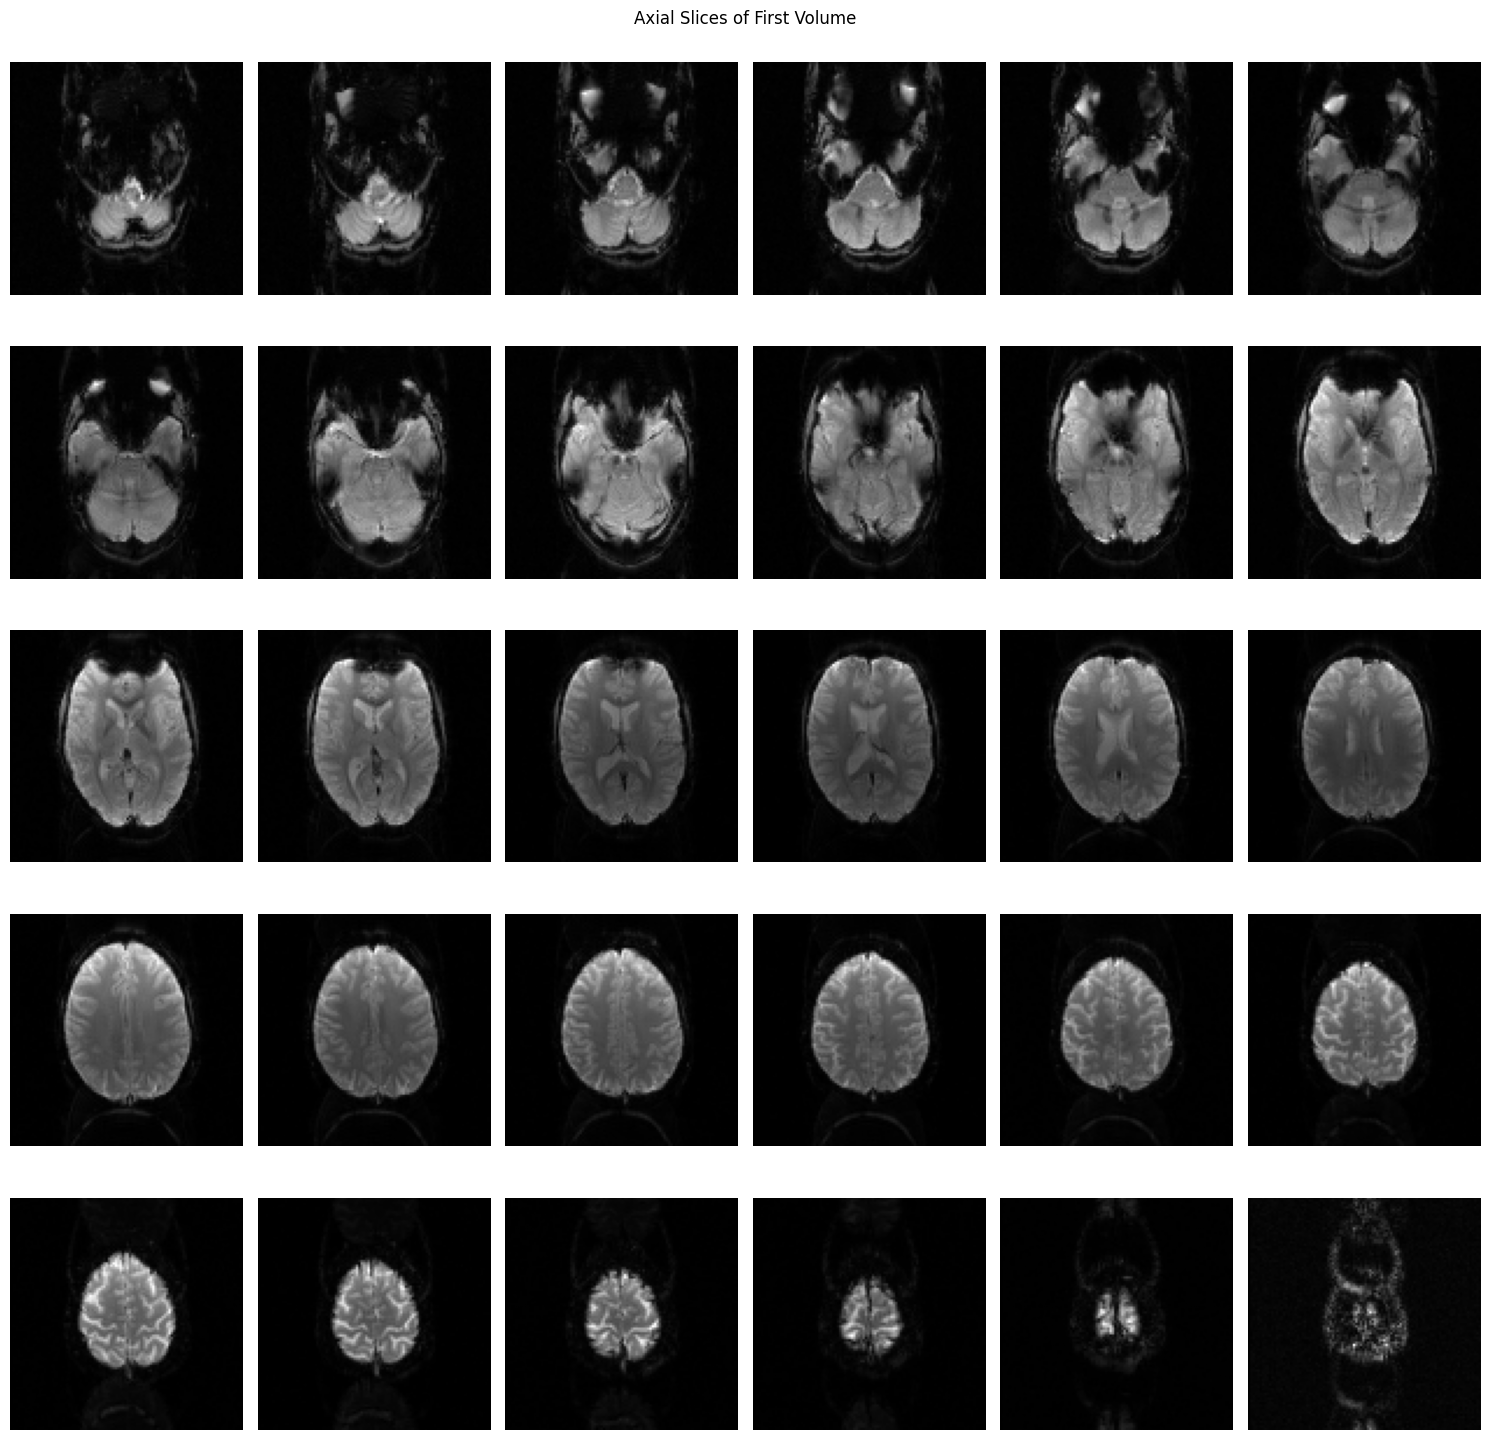

In [31]:
fig = plt.figure(figsize = (15,15))
_ =  plot_volume_as_slices(volume0, 'axial', 5, 6, colormap="gray", title='Axial Slices of First Volume')

# Preprocessing Overview

Up to this point in the course we've learned how to work with fMRI data in N-D arrays through mathematical and logical operations, saving and loading files, subsetting (indexing, slicing and masking) and visualization. Before we move onto the statistical analyses that comprise the second half of this course we must first discuss a crucial set of steps that are done before those analyses, namely **Preprocessing**.

## Purpose

As we discussed in the review above, fMRI data is **noisy**, meaning there is a lot of fluctuation in the signals we measure that are not what we are interested in studying. There are various reasons for this noise. Issues with the MRI scanner and subject movement are among several sources which we can address, although it is important to keep in mind that many sources of noise we cannot do anything about, and just have to live with. **Preprocessing** comprises a set of computations that the researcher applies to their data to address some of those sources of noise. This results in improvements in the **signal to noise ratio** (**SNR**) that we discussed in our review today. This improved **SNR** gives the researcher a better chance of finding the signal they are interested in, and thus learning something about the brain!

## Preprocessing Software Packages

There are several freely available packages created for pre-processing and analysis of fMRI brain data. They have been created at universities (for the most part) and paid for by grants. There are pros and cons to each, but those are beyond the scope of this course. Here we will briefly mention the most popular free packages and provide links for those that want more information.

### [FSL](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki)

![alt text](../../data/images/fsl_feat.gif "fsl_feat.gif")

### [SPM](http://www.fil.ion.ucl.ac.uk/spm/)
![alt text](../../data/images/SPM_Gui.png "SPM_Gui.png")

### [AFNI](https://afni.nimh.nih.gov/)
![alt text](../../data/images/AFNI_Gui.jpg "AFNI_Gui.jpg")

### [FreeSurfer](https://surfer.nmr.mgh.harvard.edu/fswiki/FreeSurferWiki)
![alt text](../../data/images/Freesurfer_GUI.jpg "Freesurfer_GUI.jpg")

## Nipype

`Nipype` is a Python module that acts as a "wrapper" around all of the above neuroimaging software (and more). A wrapper is a collection of code that calls other programs or code and provides a uniform interface to those other programs. In this case, `Nipype` provides a collection of Python objects that allows the user to seamlessly use parts of these different neuroimaging tools together, or more simply just use Python to do fMRI analysis. We will use `Nipype` combined with FSL to run most of the preprocessing steps we'll learn about today. For more information on `Nipype` follow [this link](http://nipype.readthedocs.io/en/latest/#)

# Data Artifacts

There are many ways that the scanner can output BOLD data that has errors, or **artifacts**. These artifacts wreak havoc on any data analysis we want to do, and so removing them should be the first step of any **preprocessing pipeline** (or sequence of preprocessing steps). The two most common sources of these artifacts are due to **motion and electrical spiking**. 

Dealing with data that contains artifacts is a simple process. We simply remove the bad volume and replace it with data from the previous time point. We also take note of the volumes that we removed so we can control for this in our later analysis. 

## Motion Artifacts

Volumes are usually collected one axial (or horizontal) slice at a time. To collect the data, the scanner first has to "excite" the tissue it wants to image using low-powered radio-frequency waves (completely harmless to humans). The tissue eventually "relaxes" after a short period, but if tissue is excited twice, because it's on the edge between two slices, it will cause problems. For this reason, some scan sequences collect odd numbered slices first, and then even number slices, allowing the tissue to relax. This is called an **interleaved sequence**, and is in comparison to a **descending sequence** in which the slices are collected from the top to the bottom of the brain. The problem with **interleaved sequences** is that subject motion errors are amplified. This problem is illustrated in the below image. 

The top row shows an interleaved sequence and the bottom row a descending sequence. The left column shows images collected without very much subject movement, and the right column with severe subject movement. You can see striping throughout the image with the interleaved sequence, but only a single stretched part with the descending sequence.


![alt text](../../data/images/Motion-Artifact.gif "Motion-Artifact.gif")

## Scanner Spiking Artifacts

Radio-frequency waves are simply waves in the electro-magnetic field at a specific range of frequencies. Thus interference from any source of electrical activity has the potential to interfere with how the scanner **excites** the tissue, which will cause **spiking** artifacts. Electrical interference can be caused by the presence of magnetic materials in the scanner (such as hair-clips, metalic sports-bras and metal dental work), as well as  short-circuits caused by frayed wires, leaking water, and other maintenance issues. These spikes can range from the very subtle, to the extremely obvious. It is common practice to watch the fMRI data as it is being collected at the scanner and take notes about any spiking that is observed, for later removal. Follow [this link](https://practicalfmri.blogspot.com/2012/05/rare-intermittent-epi-artifacts-spiking.html) for more on spiking artifacts.

Below is an example of some extreme spiking.

![alt text](../../data/images/W7O21v.gif "W7O21v.gif")

# Motion Correction

Humans are not robots, and so they move while in the scanner, even the best trained subjects, and even when using a 'head-case'. We've already seen one way in which motion can cause artifacts when we have an **interleaved sequence**, but there are a couple of other problems that motion causes.

Sources of noise being addressed:
* After subject moves, the neurons that are being measured in a single voxel are different.
* Movement induces warping in the image caused by magnetic field inhomogenities (called **susceptibility artifacts**). 

The motion correction stage of preprocessing attempts to fix these sources of noise in two ways. First, it finds a transformation (rotation and translation) for each volume to **align** it to the a reference image, usually the first image in the first scan of an experiment. Second, to address warping due to **susceptibility artifacts**, researchers will collect an extra scan called a **field map**. **Field maps** are pictures of the magnetic field that an algorithm can use to try to unwarp these artifacts. 

Below is an image showing how movement causes the same voxel to contain information about very different bits of tissue.

![alt text](../../data/images/Motion-Correction-1.png "moten")

Motion correction needs a **reference volume**, to which all of the other volumes will be aligned. Usual choices are the first, middle, last or mean volume. 

# Slice Time Correction

We've learned that a volume takes about 2 seconds to collect. A lot happens in the brain in 2 seconds, and so the state of the tissue being recorded in the first axial slice is very different than in the last slice almost 2 seconds later. This introduces noise across voxels, not within a voxel as motion does. When doing an analysis which compares activation across voxels, we need to correct for this difference in time so that we are comparing apples to apples.

Source of noise being addressed:
* Cross voxel differences in timing

There are several ways that researchers have addressed this issue. Traditionally BOLD data would be **interpolated** in time to put all the data on the same time frame. **Interpolation** is an operation that makes an educated guess at what your data looks like at a temporal or spatial point you haven't measured. To do this, it first draws a line (or higher-order polynomial) between the data points you have measured, and then uses the value on that line at the spatial or temporal point you want to guess. See the image below.

![alt text](../../data/images/interpolation.png "int")

The current opinion of many neuroscientists is that this type of slice time correction can cause unwanted side-effects due to the interpolation. More advanced techniques are generally used these days.

# Temporal Filtering (Detrending)

Within the BOLD signal there are several sources of noise at low frequencies (~100 second or more). There are several ways to remove these unwanted signals, one of which is **temporal filtering**. **Temporal filtering** is a technique which elimantes all low-frequency signals below a given frequency, in this case 1/100 **hertz** (cycles/per second). Any **complex signal** (such as a single voxel's BOLD timeseries) can be broken down into it's composite **simple signals**, each of which is a sine wave at a specific frequency. The image below shows 2 simple waves (in blue and red), and the resulting complex wave (in green) created by adding them together. 

![alt text](../../data/images/Frequencies.gif "Frequencies.gif")

**Temporal filtering** uses a process known as a **Fourier transformation** to break down a complex wave into its composite simple waves. It then eliminates all the simple waves below a given frequency and reassembles a new complex wave from the remaining simple waves. This new complex wave has no simple wave components below the given frequency, or **threshold**. This type of filtering is know as **high-pass filtering** because it lets only the high-frequency waves "pass-through" into the new wave.

Researchers use temporal filtering to remove low-frequency waves that result primarily from **scanner drift**, which is a term which refers to an increase in the BOLD signal over time that is caused by the superconducting magnet's field drifting over time. You can think of the MRI machine as needing to "warm up" before it delivers consistent data. Unfortunately for us, that warm-up period is often longer than an entire scan (or run).

The image on the left shows a voxel timeseries with severe scanner drift, and on the right after it's been corrected using a high-pass filter.
![alt text](../../data/images/Temporal-Detrending.png "td")


### Signal Frequency Basics

Before applying high-pass filtering to real fMRI data, let's get a better grasp of how simple waves combine to form complex waves, and how high-pass filtering can be used to remove the low fequency simple waves.

First, let's create some data that have some simple waves at various frequencies. To do that we're going to need a **helper function**. Don't worry about the code inside, we'll just be concerned with using the function.

In [51]:
def create_sine(sinefreq):
    fs = 200 # 200 frames per second
    duration = 2 #seconds
    T = duration
    nsamples = fs * T
    w = 2. * np.pi * sinefreq
    t_sine = np.linspace(0, T, nsamples, endpoint=False)
    y_sine = np.sin(w * t_sine)
    return y_sine

We'll use the above function to create data at 3 frequencies: 1, 5 and 10 hertz.

In [52]:
simplewave_1hz = create_sine(1)
simplewave_2hz = create_sine(2.5)
simplewave_10hz = create_sine(10)

Now let's plot these three waves as time series data.

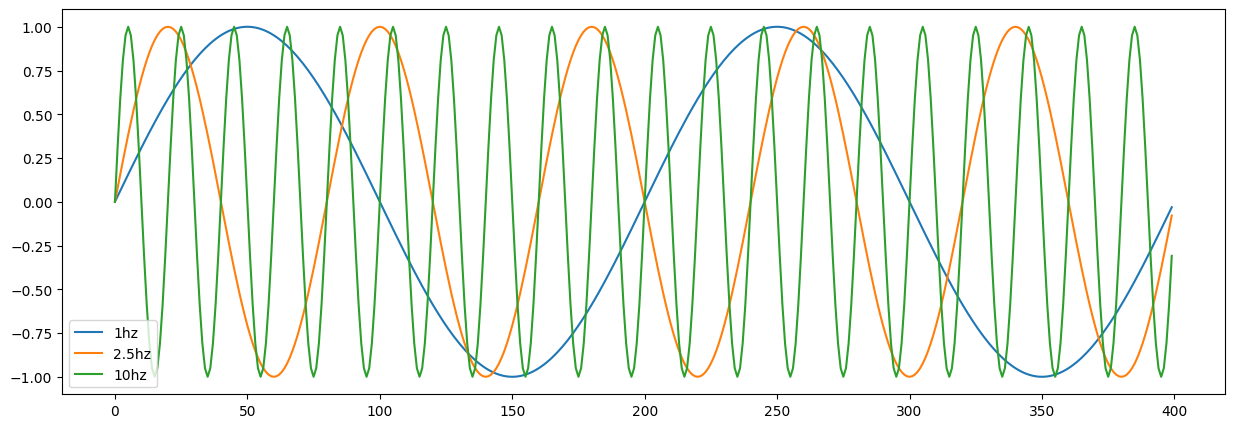

In [53]:
fig = plt.figure(figsize=(15,5))
plt.plot(simplewave_1hz, label='1hz')
plt.plot(simplewave_2hz, label='2.5hz')
plt.plot(simplewave_10hz, label='10hz')
_ = plt.legend()

Now let's add all these simple waves together to create a complex wave. To do this we simply add the arrays together.

In [54]:
complexwave = simplewave_1hz + simplewave_2hz + simplewave_10hz

And let's plot it

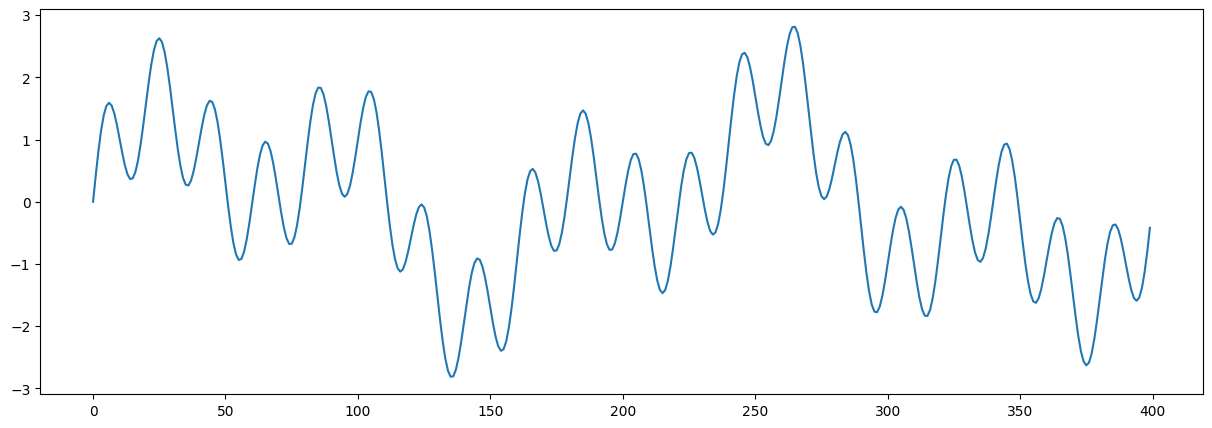

In [55]:
fig = plt.figure(figsize=(15, 5))
_ = plt.plot(complexwave)

Now let's apply a highpass filter to this complex wave. We'll need another helper function, and again don't worry about the details of this function.

In [56]:
from scipy import signal
def highpass_filter(data, cutoff, order=5):
    fs = 200 # 200 frames per second
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

Since highpass filters remove the low-frequency components of the signal and keep the high frequency components of the signal, let's try and recover just the highest signal in the complex wave, the 10hz signal. To do that, we'll set the threshold to halfway between the frewquency to keep, and the frequency to filter out. In this case we want to keep the 10hz signal, and filter out the 1hz and 2.5hz frequencies, so we'll set the threshold at 6.

In [57]:
highpass_filtered_wave_10 = highpass_filter(complexwave, 6)

And let's plot it to see if it worked. We'll plot both the original 10hz signal, and the new one.

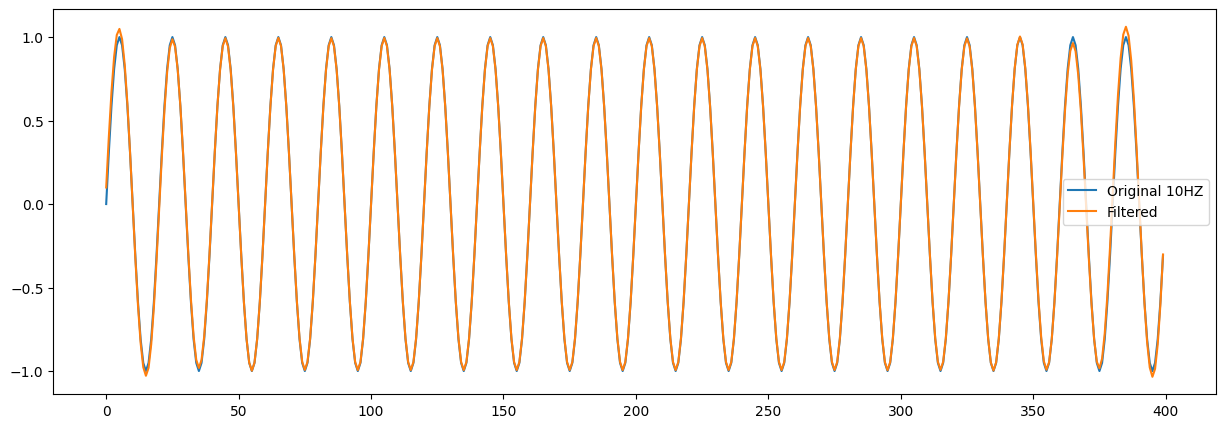

In [58]:
fig = plt.figure(figsize=(15,5))
plt.plot(simplewave_10hz, label='Original 10HZ')
plt.plot(highpass_filtered_wave_10, label='Filtered')
_ = plt.legend()

It looks pretty good! 

What would happen if you high pass filtered the complex wave using a much lower frequency threshold? Or a much higher threshold? 

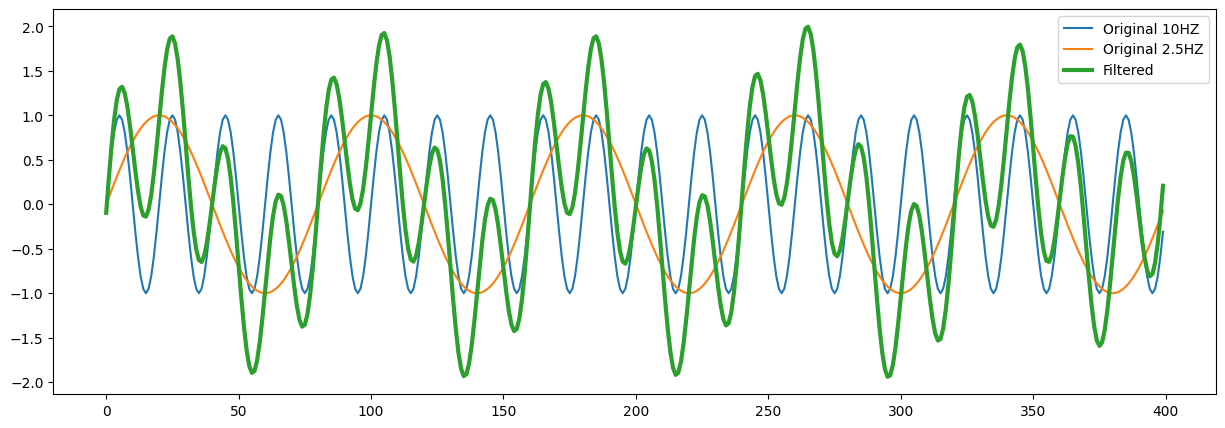

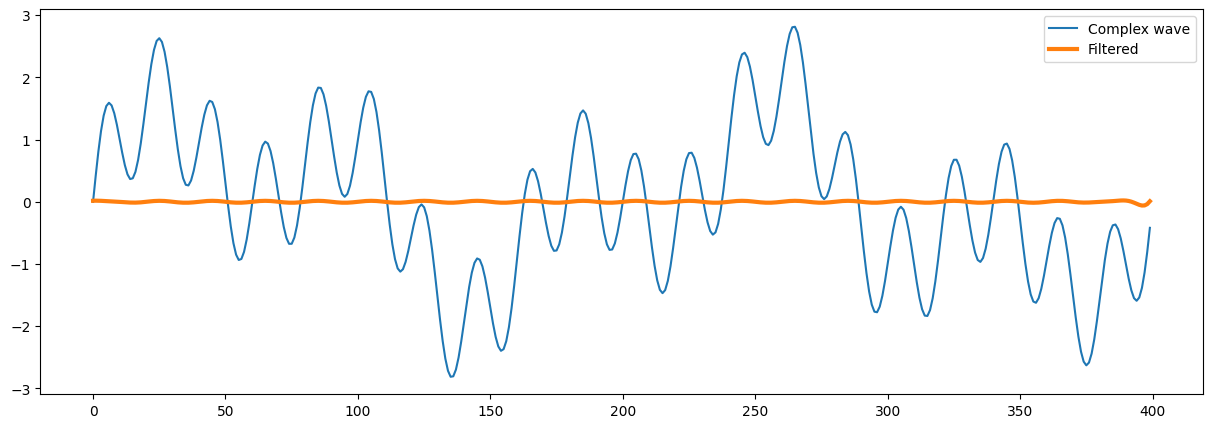

In [59]:
# Much lower frequency threshold:
highpass_filtered_wave_1_5 = highpass_filter(complexwave, 1.5)

fig = plt.figure(figsize=(15,5))
plt.plot(simplewave_10hz, label='Original 10HZ')
plt.plot(simplewave_2hz, label='Original 2.5HZ')

plt.plot(highpass_filtered_wave_1_5, label='Filtered', lw=3)
_ = plt.legend()
# --> If filtering at 1Hz, then the lower frequency, 2.5Hz becomes visible in the sum.


# Much higher frequency threshold:
highpass_filtered_wave_15 = highpass_filter(complexwave, 15)

fig = plt.figure(figsize=(15,5))
plt.plot(complexwave, label='Complex wave')

plt.plot(highpass_filtered_wave_15, label='Filtered', lw=3)
_ = plt.legend()
# --> If filtering at 15Hz, then almost nothing is left from the signal.


### Temporal filtering of FMRI Data

Now let's apply the same principle to fMRI data to remove the **scanner drift**. First let's plot a time series from a single voxel so we can get idea of what the drift looks like.

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.plot(data_slicetime[:,15,50,50])
_ = plt.title('Voxel Before Temporal Filtering')

To do the temporal filtering we'll use FSL and `nipype` again, just to be consistent with the previous preprocessing steps. We could also do this manually using the `highpas_filter` function from above.

In [ ]:
# create the temporal filtering object
temporal_filter = fsl.TemporalFilter()
temporal_filter.inputs.in_file = filename_slicetime
temporal_filter.inputs.highpass_sigma = 18.0 # 100sec filter
temporal_filter._cmd = 'fsl5.0-' + temporal_filter._cmd

And now run the temporal filtering.

**NOTE:** This takes 10 or 15 seconds to run.

In [ ]:
result_tempfilt = temporal_filter.run()

Now let's load the resulting temporally filtered data so we can plot it. Since temporal filtering removes the mean when doing a highpass filter, we must add the mean back into the data in order for plots to look correct.

In [ ]:
filename_tempfilt = result_tempfilt.outputs.out_file
img_tempfilt = nibabel.load(filename_tempfilt)
data_tempfilt = img_tempfilt.get_data().T + data_slicetime.mean(axis=0)
data_tempfilt.shape

Let's extract the same sample time series as we plotted above.

In [ ]:
timeseries_slicetime = data_slicetime[:,15,50,50]
timeseries_tempfilt = data_tempfilt[:,15,50,50]

Now let's put the two time series on the same plot so we can see how they've changed.

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.plot(timeseries_slicetime, label='Original')
plt.plot(timeseries_tempfilt, label='Temporally Filtered')
plt.legend()
plt.title('Original vs Temporally Filtered Time Series')
plt.xlabel('Time (TRs)')
_ = plt.ylabel('BOLD Signal (a.u.)')

### Breakout Session

1\. Try changing the sigma value above by using a lower and higher sigma (5 & 50) and replot the timeseries. See how the signal changes

In [ ]:
### STUDENT ANSWER

# Spatial Filtering (Smoothing) 

The scanner contains several sources of noise, one of which results in independent Gaussian (or normally distributed, or the bell curve) noise across all the voxels. One way to reduce this type of noise is to apply what's called a Gaussian filter across the BOLD data in the spatial dimensions. 

While spatial filtering has the upside of removing some of the scanner-induced Gaussian noise, there are some downsides:
* Reduces spatial resolution
* Can reduce signal if the activations are small in size

For these reasons we will not be using spatially filtered data for the remainder of the class. 

The details of spatial filtering are complex and beyond the scope of this course, but we can get an intuitive feel for what spatial filtering does and what its downsides are. We will do this here. Below is a series of images of Einstein that give a visual depiction of what spatial filtering does. 

The image on the left is the original image, the image in the middle has had Gaussian noise added to it, and the image on the right has undergone spatial filtering using a Gaussian filter. Notice that while the noise has been removed from the image on the right, it also looks more blurry because its spatial resolution has been reduced by the filtering. For this reason spatial filtering is sometimes also called smoothing.

![alt text](../../data/images/Einstein.jpg "ed")

![alt text](../../data/images/Einstein_Noise.jpg "tdn")

![alt text](../../data/images/Einstein_Denoised.jpg "tds")


### Spatial Filter Intuition

Let's get a better intuition for what Gaussian noise looks like when added to fMRI data, and when it's removed.

First, we'll extract an axial slice from the slice time data to apply noise to. Let's have a look at it before we do anything to it.

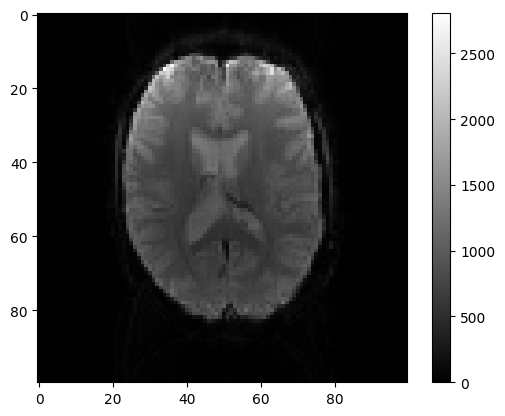

In [61]:
slice_axial_tempfilt = get_slice(volume0, 15, 'axial')
plt.imshow(slice_axial_tempfilt, cmap='gray')
_ = plt.colorbar()

Now let's add some Gaussian noise to this slice. It turns out you actually already know how to create Gaussian noise! The random data we've been created when using `np.random.randn` is actually Gaussian. The "n" in `randn` stands for **standard normal**, which is a name for Gaussian data that has a mean of `0` and a standard deviation of `1`. So let's use `np.random.randn` to create some Gaussian noise and add it to the slice. We want to multiply that noise by some fraction of the max value in the image, since the normal data has very small magnitudes. Let's choose to add noise that is 20% of the max value of the slice.

In [62]:
max_value = slice_axial_tempfilt.max()
slice_dim = slice_axial_tempfilt.shape[0]
noise = np.random.randn(slice_dim, slice_dim) * (0.2 * max_value)
slice_axial_tempfilt_noise = slice_axial_tempfilt + noise

Now let's plot the two images side by side to see the difference.

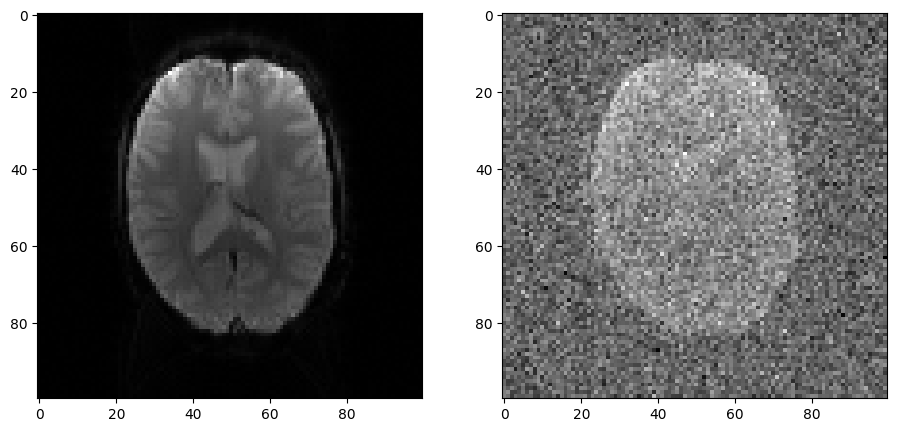

In [63]:
fig = plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
_ = plt.imshow(slice_axial_tempfilt, cmap='gray')
plt.subplot(1,2,2)
_ = plt.imshow(slice_axial_tempfilt_noise, cmap='gray')

That's definitely noticeable, it looks like static on old-school TVs. 

Now that we've seen what somewhat extreme noise looks like, let's remove it using spatial filtering. To do so we'll use `gaussian_filter`. It takes the data to use, and the size of the filter, which we'll set to 4.

In [64]:
from scipy.ndimage.filters import gaussian_filter
slice_axial_tempfilt_filtered = gaussian_filter(slice_axial_tempfilt_noise, 4)

slice_axial_tempfilt_filtered_no_noise = gaussian_filter(slice_axial_tempfilt, 4)

/tmp/ipykernel_2246517/212364117.py:1: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


Now let's plot all 3 images to see the full effects of adding noise and filtering it out.

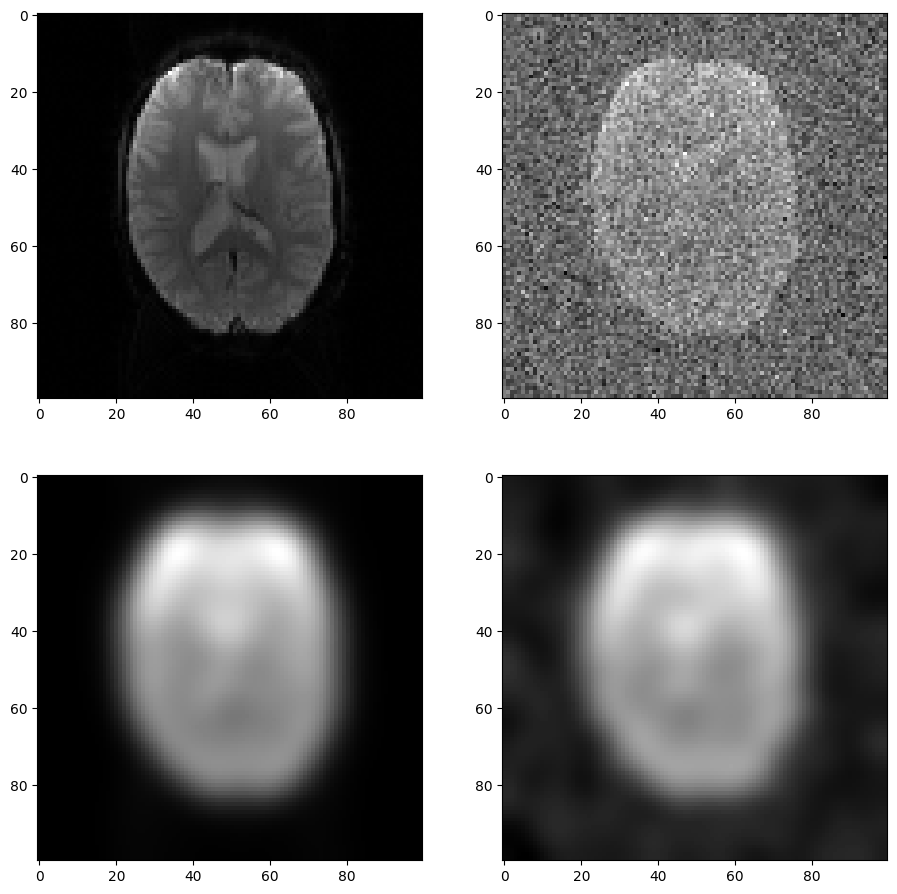

In [65]:
fig = plt.figure(figsize=(11,11))
plt.subplot(2,2,1)
plt.imshow(slice_axial_tempfilt, cmap='gray')
plt.subplot(2,2,2)
plt.imshow(slice_axial_tempfilt_noise, cmap='gray')
plt.subplot(2,2,4)
plt.imshow(slice_axial_tempfilt_filtered, cmap='gray')

plt.subplot(2, 2, 3)
_  = plt.imshow(slice_axial_tempfilt_filtered_no_noise, cmap='gray')

# Temporal Normalization (Z-Score)

Within statistics and signal processing the term **normalization** refers to a number of different computations that "adjust values measured on different scales to a notionally common scale". That "notionally common scale" can be the range between zero and one, for example, meaning the maximum value in the data becomes `1` and the minimum value in the data becomes `0`. **Normalization** is done for a number of reasons ranging from simply making data more interpretable, to removing irrelevant differences in signals to allow for their joint analyses. For more on **normalization** see <a href="https://en.wikipedia.org/wiki/Normalization_(statistics)">here</a>.

**Temporal normalization** is simply the process of normalization applied to data in the time domain. In the case of fMRI, that means normalizing each voxel time series, across all the runs of a subject so they are on the same scale. 

We'll cover two types of **normalization** today:

1\. **Feature Scaling:** Puts all the data into the range [0-1] (the brackets mean inclusive). <br/>Formula:

\begin{align}
X^{\prime} & = \frac{X - X_{min}}{X_{max}-X_{min}}
\end{align}
where $X^{\prime}$ is the feature scaled data, $X$ is the original data, $X_{min}$ is the minimum value of the data, and $X_{max}$ is the maximum value of the data.

2\. **Standard Scoring (Z-Scoring):** Makes the mean of the data equal `0` and the standard deviation of the data equal `1`. <br/>Formula:
\begin{align}
Z & = \frac{X - \mu}{\sigma}
\end{align}
where $X$ is the data, $\mu$ is the mean of the data, and $\sigma$ is the **standard deviation** of the data.

Let's get familiar with **normalization** by exploring **feature scaling** one step at a time.

## Feature Scaling

Feature scaling is perhaps the simplest form of **normalization**, and is conceptually easy to understand. The idea is to move all of the data to a known range, in this case from [0-1]. Let's create a toy array of random data to practice with, then plot it. 

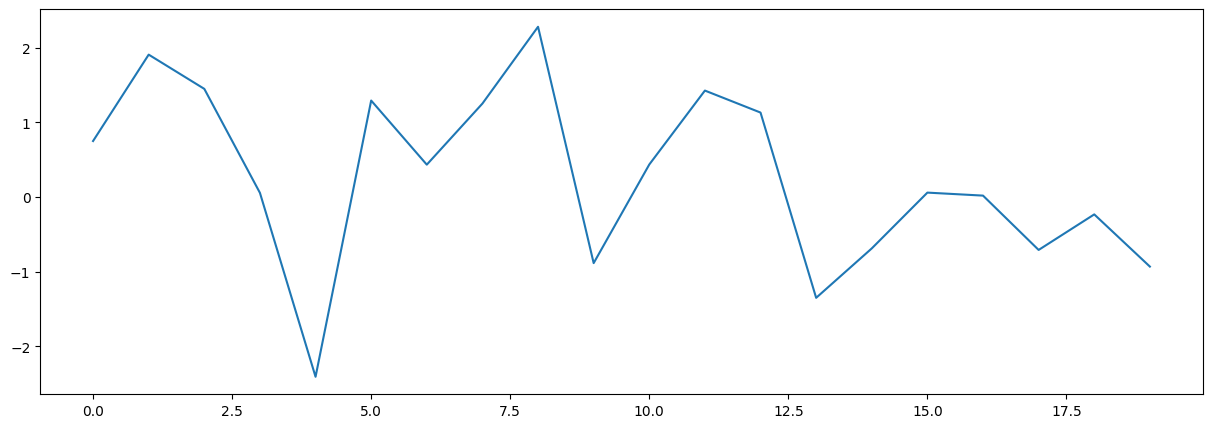

In [67]:
array_random = np.random.randn(20)
fig = plt.figure(figsize=(15,5))
_ = plt.plot(array_random)

The first step of **feature scaling** is to remove the minimum value from the data. Let's see what that does:

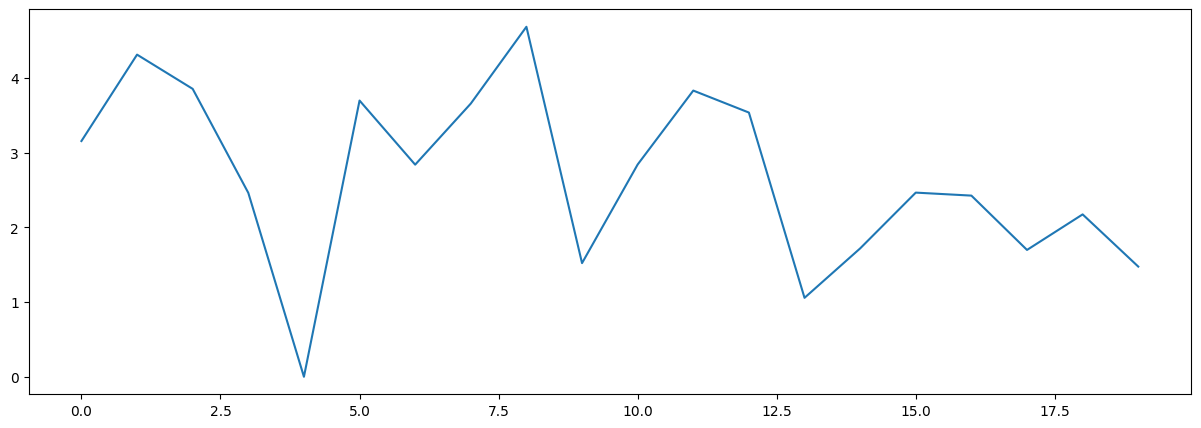

In [68]:
array_random_offset = array_random - array_random.min()
fig = plt.figure(figsize=(15,5))
_ = plt.plot(array_random_offset)

Huh, the plot looks the same, so what's the difference? Removing the minimum value does not change the shape of the data, it simply **offsets** (or shifts along the y-axis) the data, making the new minimum value equal to zero. So we can see the change only in the values of the y-axis. Notice the lowest value is now `0`, when it was around `-1` before.

The second step of **feature scaling** is to divide all the data by the new maximum value. Let's do that here:

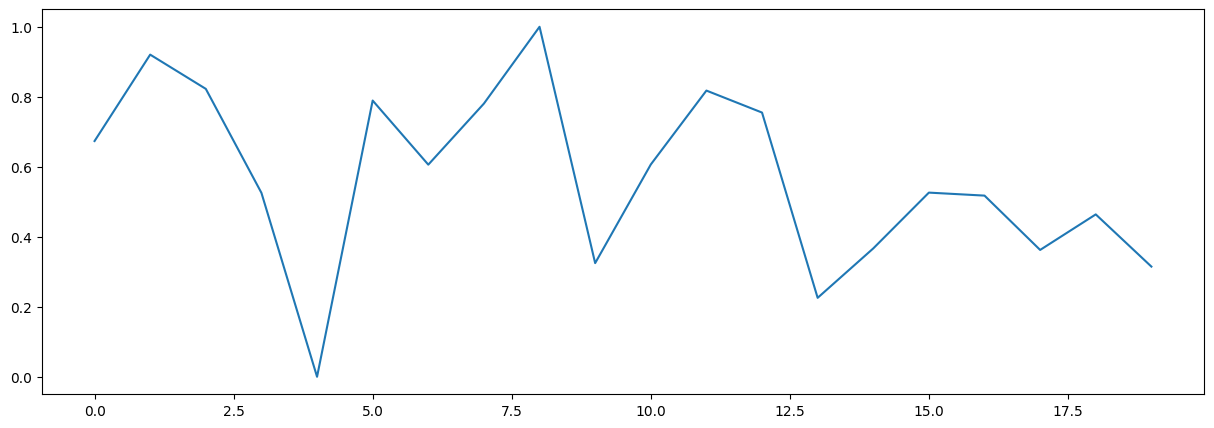

In [69]:
array_random_featurescaled = array_random_offset / array_random_offset.max()
fig = plt.figure(figsize=(15,5))
_ = plt.plot(array_random_featurescaled)

What changed this time? Again, the plot looks the same, only the scale of the data (on the y-axis) has changed. By dividing the offset data by it's new max value, we've **scaled** the data so it's new maximum is `1`. That's true because dividing a number by itself always equals one, so dividing all the numbers by the maximum means the new maximum has to be `1`. Also, since the new minimum was `0`, dividing `0` by any number always returns zero. So now our data is guaranteed to be on the range [0-1]!

Important to note is that **normalization** does not change the shape of your data, it simply applies an **offset**, and then **scales** the data.

We can combine both the offset and scaling into a single line of code for conveneince. Let's remind ourselves of the equation for features scaling first:

\begin{align}
X^{\prime} & = \frac{X - X_{min}}{X_{max}-X_{min}}
\end{align}

In [70]:
array_random_featurescaled2 = (array_random - array_random.min()) / (array_random.max() - array_random.min())

print(array_random_featurescaled)
print(array_random_featurescaled2)

[0.6735383  0.92041063 0.82258582 0.52547918 0.         0.78922895
 0.60606576 0.78060168 1.         0.32475135 0.60649329 0.81772191
 0.75489641 0.22556513 0.36676547 0.52618488 0.51762286 0.36240427
 0.46395379 0.31483107]
[0.6735383  0.92041063 0.82258582 0.52547918 0.         0.78922895
 0.60606576 0.78060168 1.         0.32475135 0.60649329 0.81772191
 0.75489641 0.22556513 0.36676547 0.52618488 0.51762286 0.36240427
 0.46395379 0.31483107]


The values from both ways of feature scaling look the same, but the code this new way looks a little different than when we did it the first time. That's because in the first way we did it, we used the maximum value from the array that already had the minimum removed. Since the new way uses the original `array_random` everywhere, we have to remove the minimum from the maximum explicity.

## Problems with Feature Scaling

**Feature scaling** is very useful to put data into an easily interpretable scale, however a problem with this normalization method shows up when you have outlying values far way from the mean. What would happen if we add a very large outlying value at a single time point? Let's see!

In [71]:
array_random_long = np.random.randn(100)
array_random_outlier = copy.copy(array_random_long)
array_random_outlier[80] = array_random_outlier.max()*20

To visualize what's happening in these data sets we'll use

In [72]:

def feature_scale(data, dim=0):
    """Normalize data to range of 0-1 by subtracting min, dividing by range"""
    data_norm = (data - data.min(axis=dim, keepdims=True)) / (data.max(axis=dim, keepdims=True) - data.min(axis=dim, keepdims=True))
    return data_norm

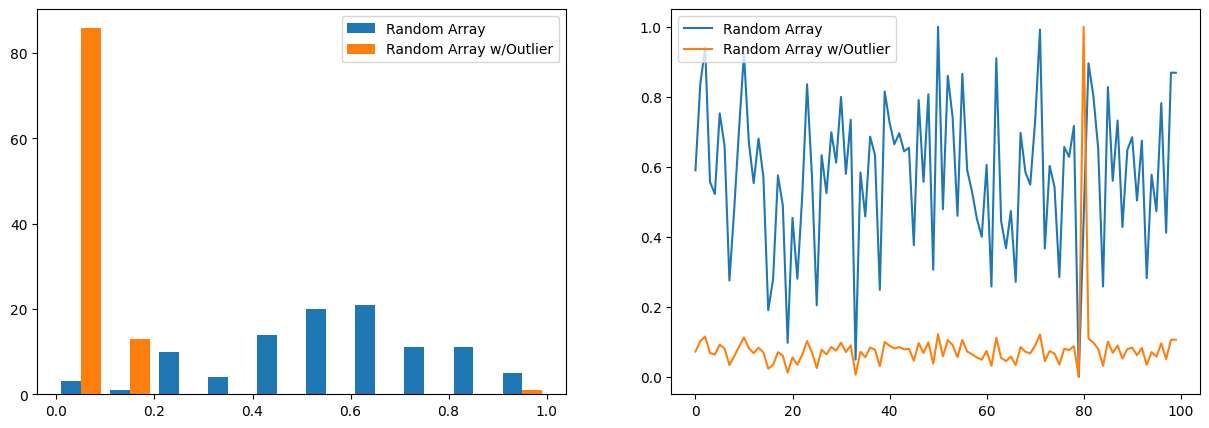

In [73]:
array_random_stacked = np.stack((feature_scale(array_random_long), feature_scale(array_random_outlier)), axis=1)

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(array_random_stacked, 10)
_ = plt.legend(('Random Array', 'Random Array w/Outlier'))
plt.subplot(1,2,2)
plt.plot(array_random_stacked)
_ = plt.legend(('Random Array', 'Random Array w/Outlier'))


Looking at the histogram, the array with the outlier has most of its data lying in a single bin of the histogram. Feature scaling does not put the data from both arrays into a similar range, because the max value is not stable (it can change a lot depending on only one data point). As we've learned, (linear) data normalization involves an *offset* operation (by subtracting off some value) and a **scaling** operation (by dividing by some value or performing some nonlinear operation). 

A more robust and stable way to normalize data is to subtract the **mean** of the data instead of the min, and to divide by the **standard deviation** instead of the range (max - min). As was outlined above, this is exactly what z-scoring does. Let's learn more about it now.

## Standard Scoring (Z-Scoring)

One of the most commonly used forms of **normalization** is to creating standard scores, or z-scores. A z-scored dataset has a mean of 0, and a standard deviation of 1. So what's a standard deviation? Let's find out.

### Standard Deviation

**Standard deviation** is a descriptive statistic that measures the average distance away from the mean (in either direction) of a data set. When a data set has a small standard deviation, the data points tend to be close to the mean, when the standard deviation is large the data points tend to be far from the mean. 

Before we jump into the equation for the standard deviation, let's get a visual intuition for what the standard deviation looks like by plotting the distribution of some random Gaussian data. We learned earlier today that `np.random.randn` actually gives us **standard normal** data, whose **distribution** is Gaussian (shaped like the Bell curve), and whose mean is `0` and standard deviation is `1`. We'll plot the data using a histogram, since that plots the **distribution** of the data. Then we'll draw a line for the mean, and two lines for standard deviation on either side of the mean. 

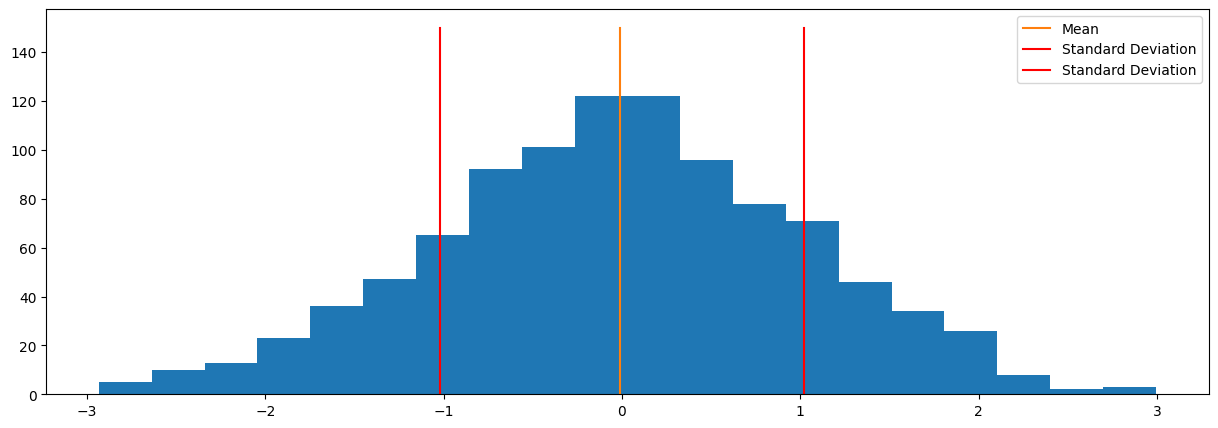

In [74]:
data_stddev = np.random.randn(1000)
fig = plt.figure(figsize=(15,5))
_ = plt.hist(data_stddev, bins=20)
_ = plt.plot([data_stddev.mean(), data_stddev.mean()], [0,150], label='Mean')
_ = plt.plot([-data_stddev.std(), -data_stddev.std()], [0,150], 'r', label='Standard Deviation')
_ = plt.plot([data_stddev.std(), data_stddev.std()], [0,150], 'r', label='Standard Deviation')
_ = plt.legend()

Now let's look at how to calculate the standard deviation. The formula is a bit complicated-looking, but we'll work through it step by step to see it's actually not that bad.

$$\hat{\sigma} = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \overline{x})^2}$$

where $\hat{\sigma}$ is the estimated standard deviation, $N$ is the number of samples in your data set, $x_i$ is the ith data point, and $\overline{x}$ is the mean of the data set.

When tryring to understand a formula, it can be useful to pick it apart starting with the innermost calculation, and work outwards. Let's do that here, starting with:
$$\sum_{i=1}^N (x_i - \overline{x})^2$$

That Greek letter ($\sum$) is an uppercase "sigma" and stands for the `sum` operation. In this case it means to sum all that's in the parentheses, across all the $x_i$ values. So this expression is saying, for each data point:
1. Subtract the mean
2. Square that difference

And then sum all those squared differences. This sum is calculated many places in statistics, and is called the **sum of squared differences**, or **sum of squares** for short. Let's do that here:

In [75]:
x = array_random
differences = x - x.mean()
differences_squared = differences**2
sum_squares = differences_squared.sum()
sum_squares

np.float64(27.31141083271527)

Or we can put that all into a single line of code like this:

In [76]:
sum_squares = np.sum((x - x.mean())**2)

That was really the hard part! Now we take that value, divide it by $N$, and take the square root:

In [77]:
N = x.shape[0]
std_dev = np.sqrt(sum_squares / N)
std_dev

np.float64(1.1685762883251412)

The standard deviation is such a common operation that there is a function for it, `std`. Let's verify we got the same answer as the numpy function:

In [78]:
x.std()

np.float64(1.1685762883251412)

### Creating Z-Scores

Now that we know what a standard deviation is, we can calculate z-scores. Remember that z-scoring makes the mean of the data `0`, and the standard deviation of the data `1`. To do that we'll use the same logic as we did with **feature scaling**. To make the mean zero, we'll **offset** (or subtract) the data by the mean. Then to make the standard deviation `1`, we'll divide that by the standard deviation. Here's the equation, which is actually very simple:

\begin{align}
Z & = \frac{X - \mu}{\sigma}
\end{align}

Let's create z-scores from the original array of random data `array_random` here:

In [80]:
array_random_zscore = (array_random - array_random.mean()) / array_random.std()
array_random_zscore

array([ 0.4153491 ,  1.40526001,  1.01300121, -0.17833971, -2.28541086,
        0.8792465 ,  0.14479711,  0.84465281,  1.72439817, -0.98321998,
        0.1465114 ,  0.99349785,  0.74157959, -1.38093776, -0.81475135,
       -0.17550997, -0.20984204, -0.83223893, -0.42504477, -1.02299839])

There is also a function to do z-scoring for us already in python, it is called `zscore` and is in the module `scipy.stats`. Let's import it and use it to verify that our answer is correct. 

In [81]:
from scipy.stats import zscore
array_random_zscore2 = zscore(array_random, axis=0)
print(array_random_zscore)
print(array_random_zscore2)

[ 0.4153491   1.40526001  1.01300121 -0.17833971 -2.28541086  0.8792465
  0.14479711  0.84465281  1.72439817 -0.98321998  0.1465114   0.99349785
  0.74157959 -1.38093776 -0.81475135 -0.17550997 -0.20984204 -0.83223893
 -0.42504477 -1.02299839]
[ 0.4153491   1.40526001  1.01300121 -0.17833971 -2.28541086  0.8792465
  0.14479711  0.84465281  1.72439817 -0.98321998  0.1465114   0.99349785
  0.74157959 -1.38093776 -0.81475135 -0.17550997 -0.20984204 -0.83223893
 -0.42504477 -1.02299839]


Yup, we did it right!

Now let's see how z-scoring changed the data by creating line plots like we did when **norming** (doing normalization) with **feature scaling** above.

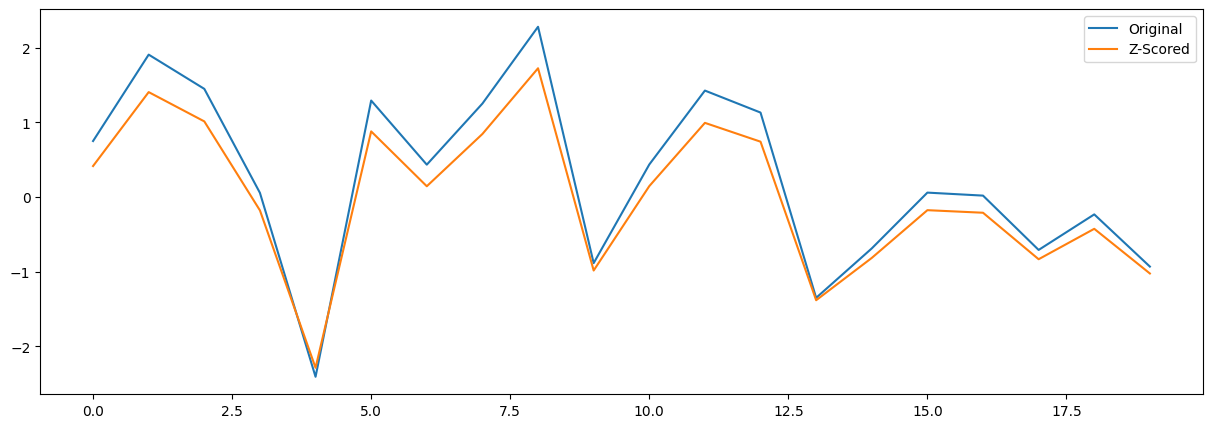

In [82]:
fig = plt.figure(figsize=(15,5))
_= plt.plot(array_random, label='Original')
_= plt.plot(array_random_zscore, label='Z-Scored')
_ = plt.legend()

Since the random data array we created was actualy drawn from a **standard normal** distribution it's mean was already almost `0` and it's standard deviation almost `1`, so z-scoring didn't change things that much here! Let's move on to some real fMRI data where that won't be the case.

### Z-Scoring fMRI data

We've learned that values recorded by fMRI data is recorded in arbitrary units, and about issues such as **scanner drift**. For both of these reasons, and others, the raw values of fMRI BOLD data can vary drastically between different runs on the same subject in the same day. Another way to say this, is that we're really just concerned with relative differences in the BOLD signal, and not the absolute differences. **Temporal normalization** is often used to remove these meaningless differences is signal between scans of the same subject. Z-scoring is the most common form of this.

Let's load 2 more scans worth of data from this subject in order to practice z-scoring with:

In [86]:
img_preproc2 = nibabel.load('../../data/fMRI/categories/s01_categories_02.nii.gz')
data_preproc2 = img_preproc2.get_fdata().T
img_preproc3 = nibabel.load('../../data/fMRI/categories/s01_categories_03.nii.gz')
data_preproc3 = img_preproc3.get_fdata().T

To illustrate z-scoring on real fMRI data we'll extract a single voxel time series from all 3 scans. 

In [87]:
timeseries1 = data_preproc[:, 6, 57, 37]
timeseries2 = data_preproc2[:, 6, 57, 37]
timeseries3 = data_preproc3[:, 6, 57, 37]
timeseries3.shape

(120,)

Now we will contatenate these time series together to have a lot of data for analysis. We'll use `np.concatenate` to make a single 1-D array of the 3 time series in a row.

In [88]:
timeseries_total = np.concatenate((timeseries1, timeseries2, timeseries3), axis=0)
timeseries_total.shape

(360,)

Before we start the z-scoring process, let's plot the data to see why we need to z-score in the first place.

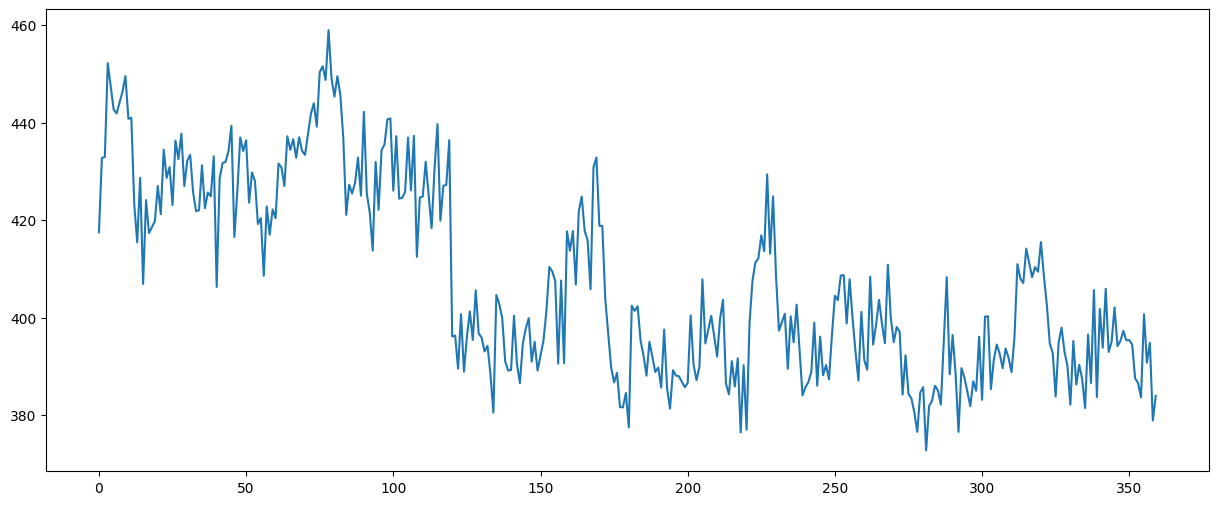

In [89]:
plt.figure(figsize=(15, 6))
_ = plt.plot(timeseries_total)

The signals of each run seem to vary around very different mean values! Let's visualize this by drawing some lines into the plot that represent the mean of the 3 scans.

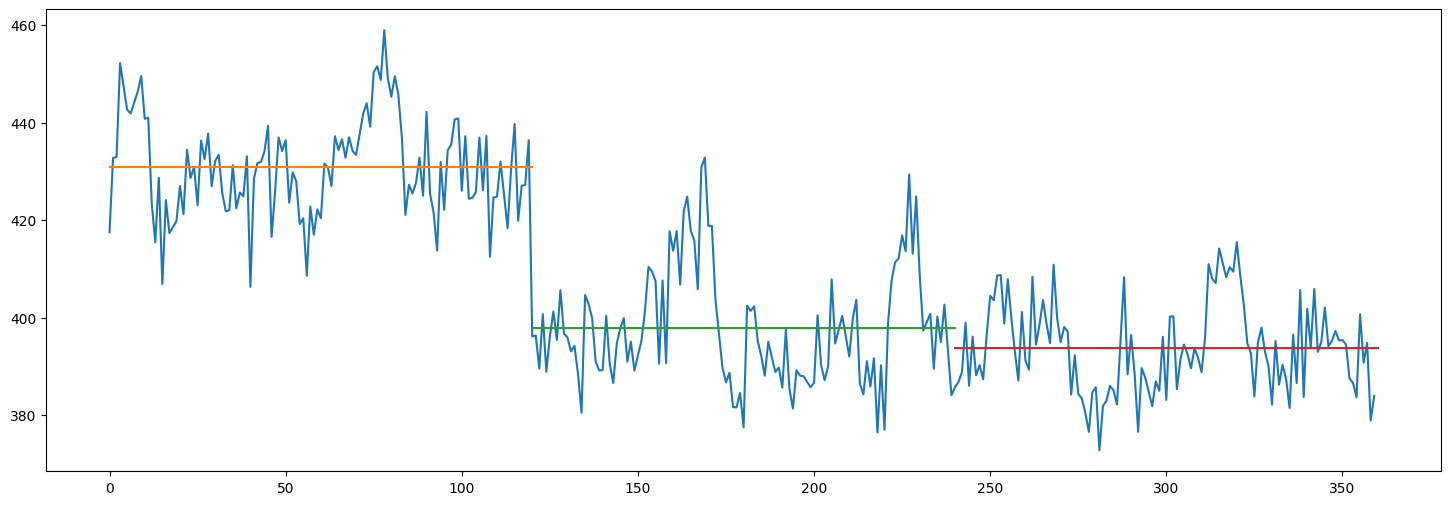

In [90]:
plt.figure(figsize=(18, 6))
plt.plot(timeseries_total)
mean1 = timeseries1.mean()
mean2 = timeseries2.mean()
mean3 = timeseries3.mean()
timeseries_len = timeseries1.shape[0]
plt.plot([0, timeseries_len], [mean1, mean1])
plt.plot([timeseries_len, timeseries_len*2], [mean2, mean2])
_ = plt.plot([timeseries_len*2, timeseries_len*3], [mean3, mean3])

Now let's take the first stage of z-scoring, to subtract the mean. We'll be z-scoring each timeseries separately, so we'll subtract the mean of each timeseries separately here.

In [91]:
timeseries1_nomean = timeseries1 - mean1
timeseries2_nomean = timeseries2 - mean2
timeseries3_nomean = timeseries3 - mean3
timeseries_total_nomean = np.concatenate((timeseries1_nomean, timeseries2_nomean, timeseries3_nomean))

Now let's plot the total time series with the means removed from the 3 time series.

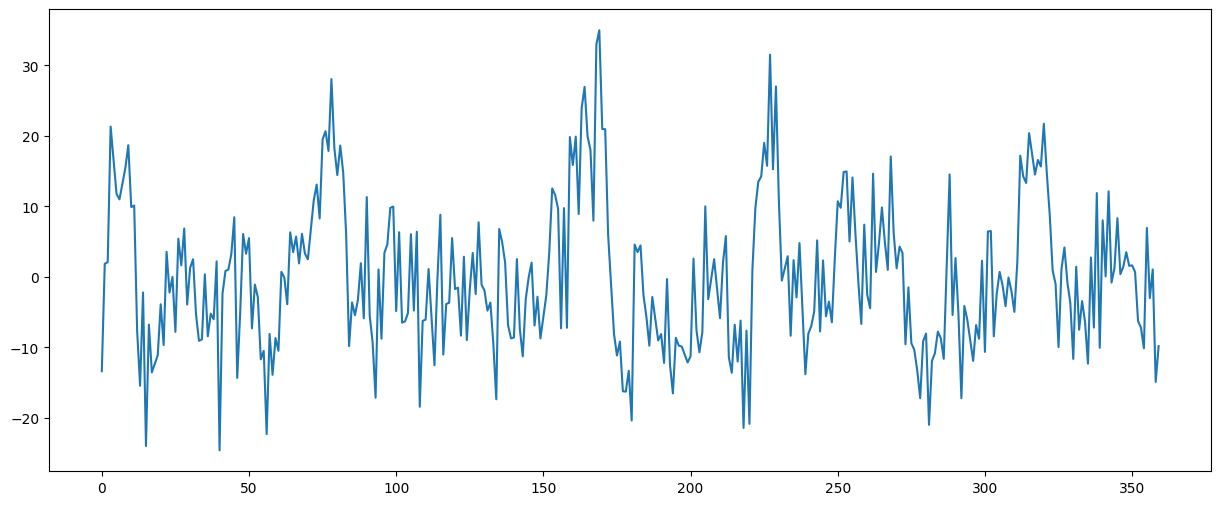

In [92]:
plt.figure(figsize=(15, 6))
_ = plt.plot(timeseries_total_nomean)

The total time series now looks a lot more similar. There could still be differences in the average amount of difference from the means (which is the standard deviation!), however. Let's calculate the standard deviations and plot them usnig colored strips that center on the mean. We'll use a different color for each scan.

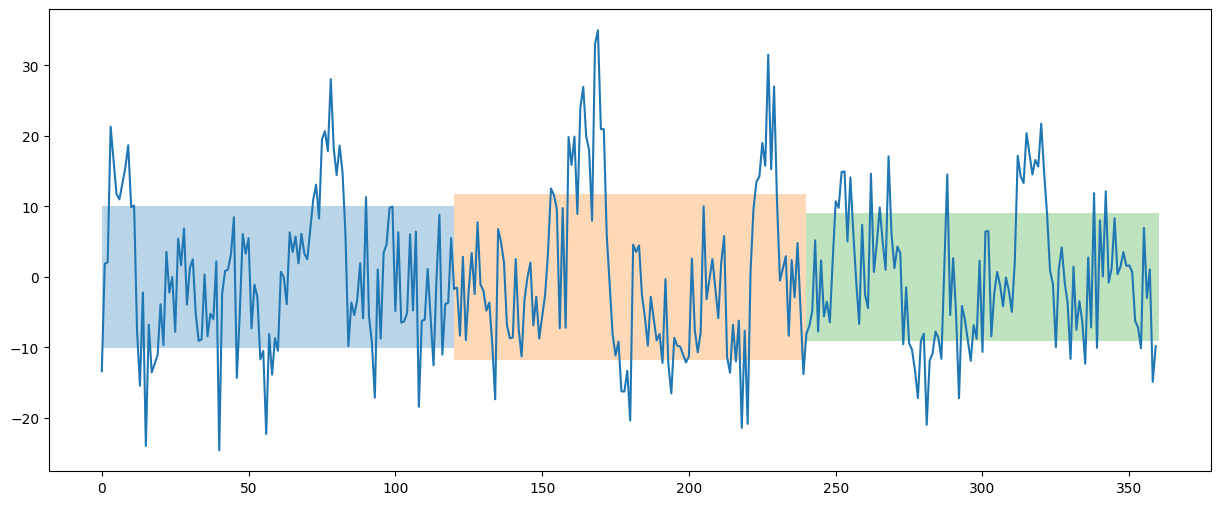

In [93]:
stdev1 = np.std(timeseries1_nomean)
stdev2 = np.std(timeseries2_nomean)
stdev3 = np.std(timeseries3_nomean)

plt.figure(figsize=(15, 6))
plt.plot(timeseries_total_nomean)
plt.fill_between([0, timeseries_len], [-stdev1, -stdev1], [stdev1, stdev1], alpha=.3)
plt.fill_between([timeseries_len, timeseries_len*2], [-stdev2, -stdev2], [stdev2, stdev2], alpha=.3)
_ = plt.fill_between([timeseries_len*2, timeseries_len*3], [-stdev3, -stdev3], [stdev3, stdev3], alpha=.3)

We can see the heights of the 3 colored strips are different, which indicates the standard deviation differs across the 3 runs. Let's complete the z-scoring process and divide each scan's time series by the standard deviation, separately.

In [94]:
timeseries1_zscore = timeseries1_nomean / stdev1
timeseries2_zscore = timeseries1_nomean / stdev2
timeseries3_zscore = timeseries1_nomean / stdev3
timeseries_total_zscore = np.concatenate((timeseries1_zscore, timeseries2_zscore, timeseries3_zscore))

And finally we'll plot the z-scored time series along with the original concatonated time series so we can see how z-scoring changed the values.

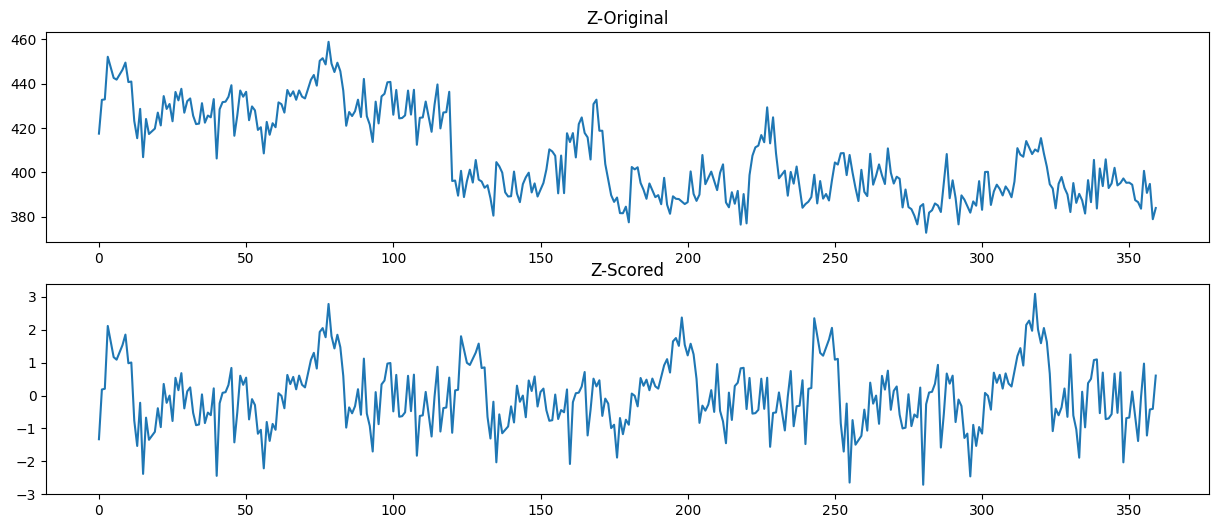

In [95]:
plt.figure(figsize=(15, 6))
plt.subplot(2,1,1)
_ = plt.plot(timeseries_total)
_ = plt.title('Z-Original')
plt.subplot(2,1,2)
_ = plt.plot(timeseries_total_zscore)
_ = plt.title('Z-Scored')

## Recap: Preprocessing Steps

While the goal of preprocessing remains the same for all researchers, to improve SNR, the specific steps chosen can vary. Additionally the order in which they are executed and the algorithms used to do each step can vary as well. Below is an outline of the most common preprocessing steps with a brief description of each. We will cover each of them in more detail below, except the conversion to NIFTI, since we have already discussed this in a previous lecture. 

1. **Conversion from Dicom to NIFTI**: Convert the MRI output Dicom file format into the NIFTI neuroimaging file format for use in the analyses packages mentioned above. 
2. **Remove Scanner Artifacts**: The scanner is a complex piece of machinery that does have occasional problems. Examining and removing data that contains "scanner artifacts" created by these occasional problems is important.
3. **Motion Correction**: The subject moves during every scan, even the best trained subjects. Motion correction is the process of rotating and translating each volume of functional data so it is in the exact same place across every scan.
5. **Slice Time Correction**: It takes ~2 seconds to collect an entire functional image of the brain, and a lot happens in the brain in that time period. Slice time correction is the process of resampling the data so that every voxel in a given volume represents the exact same point in time. 
6. **Temporal Filtering (High-Pass Filter)**: The scanner and subject are both prone to cyclical changes that can cause the signal we record to by distorted at a very low frequency (such as breathing and "scanner drift"). Temporal filtering removes those low-frequncy noise signals.
7. **Spatial Filtering (Smoothing)**: When combining data across subjects, using a spatial filter can improve SNR if we assume that the signal we are looking for has the same properties as the spatial filter we use.
8. **Temporal Normalization (Z-Score)**: The values in our fMRI data can vary in their mean and variance across runs due to processess unimportant to our analyses. It is important then to control for these differences by z-scoring each run individually.


![alt text](../../data/images/fmri-preprocessing-steps-in-spm8-3-638.jpg "fmri-preprocessing-steps-in-spm8-3-638.jpg")


### For group statistics

In addition to the preprocessing steps just mentioned, there are 2 additional steps that most researchers do in order to facilitate group level analyses, which are statistics computed across the entire group of subjects. We will not be doing either of these steps in this class, but it is important to know about these two steps since many studies use them.

1. **Registration (Functional to anatomical)**: This step is similar to motion correction, as it is finding a rotation and translation of the functional data so that it is in the same place in 3D space as the anatomical scan. This is a necessary first step for **Spatial Normalization**.
2. **Spatial Normalization (Single subject to standard 3D space)**: In order to do statistics across all the subjects, the data needs to be in the same 3D space. This is tricky because every brain is shaped slightly different. The process of spatial normalization finds a very complex (non-linear) transformation that maps every voxel in the subjects' anatomical scans into a standard 3D space.